In [51]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

from astroML.utils import completeness_contamination
from astroML.classification import GMMBayes
from astroML.utils import pickle_results

import corner

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [8,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

In [52]:
file = '../solutions/galaxyquasar.csv'
data= np.genfromtxt(file, delimiter=',', dtype = str)
print(data)

[['u' 'g' 'r' ... 'class' 'z1' 'zerr']
 ['18.97213' '18.53676' '18.5828' ... 'QSO' '0.5228189' '0.0001547483']
 ['19.24592' '17.47646' '16.47817' ... 'GALAXY' '0.1228459'
  '2.816076E-05']
 ...
 ['18.62718' '17.30876' '16.87371' ... 'GALAXY' '0.05442934'
  '8.433598E-06']
 ['19.5514' '18.27711' '17.62101' ... 'GALAXY' '0.1125709' '9.286238E-06']
 ['18.80772' '17.75751' '17.405' ... 'GALAXY' '0.04365238' '7.415751E-06']]


In [53]:
#colors
ug = data[1:,0].astype(float) - data[1:,1].astype(float)
gr = data[1:,1].astype(float) - data[1:,2].astype(float)
ri = data[1:,2].astype(float) - data[1:,3].astype(float)
iz = data[1:,3].astype(float) - data[1:,4].astype(float)

galaxies = data[1:,0:4][data[1:,5]=='GALAXY'].astype(float)
quasars = data[1:,0:4][data[1:,5]=='QSO'].astype(float)

labels = np.char.replace(data[1:,5], 'GALAXY', '0')
labels = np.char.replace(labels, 'QSO', '1').astype(float)

In [54]:
ug_train, ug_test, gr_train, gr_test, ri_train, ri_test, iz_train, iz_test, labels_train, labels_test = train_test_split(ug, gr, ri, iz, labels, test_size=0.3)


In [55]:
colors_train = np.column_stack((ug_train, gr_train, ri_train, iz_train))
colors_test = np.column_stack((ug_test, gr_test, ri_test, iz_test))
labels_corner = [r'$u-g$', r'$g-r$', r'$r-i$', r'$i-z$']

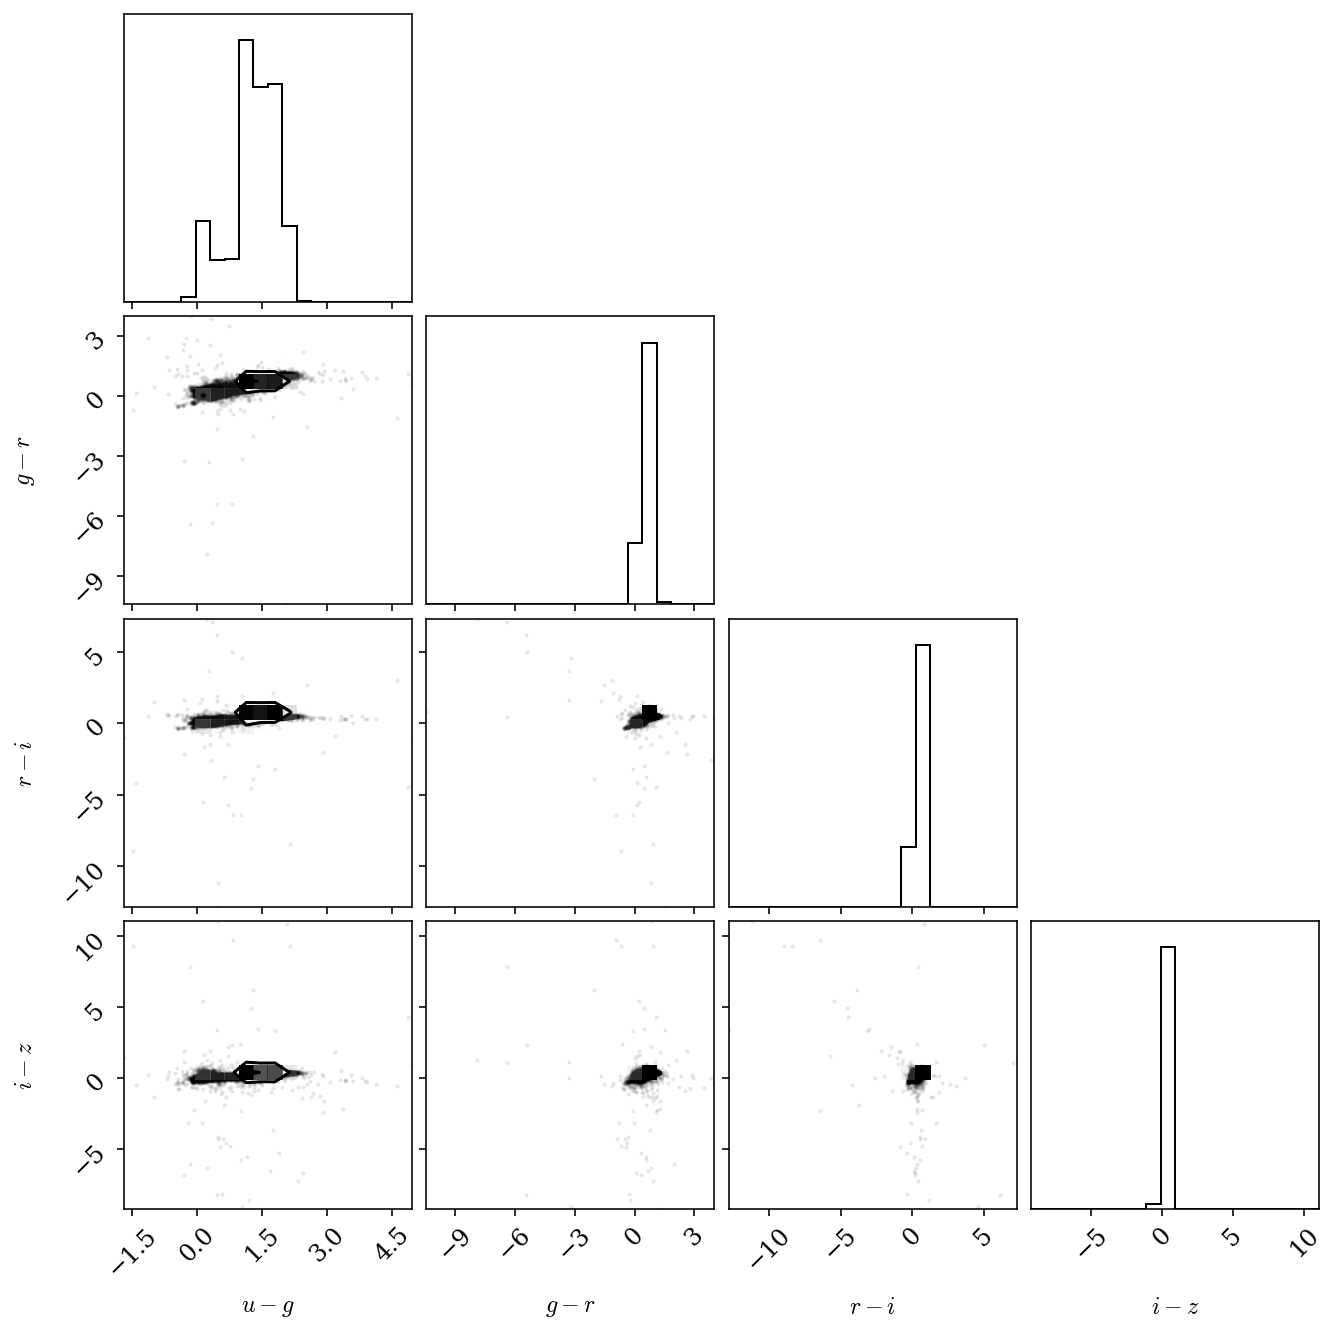

In [56]:
corner.corner(colors_train, labels = labels_corner);

$u-g$ is the most promising color 

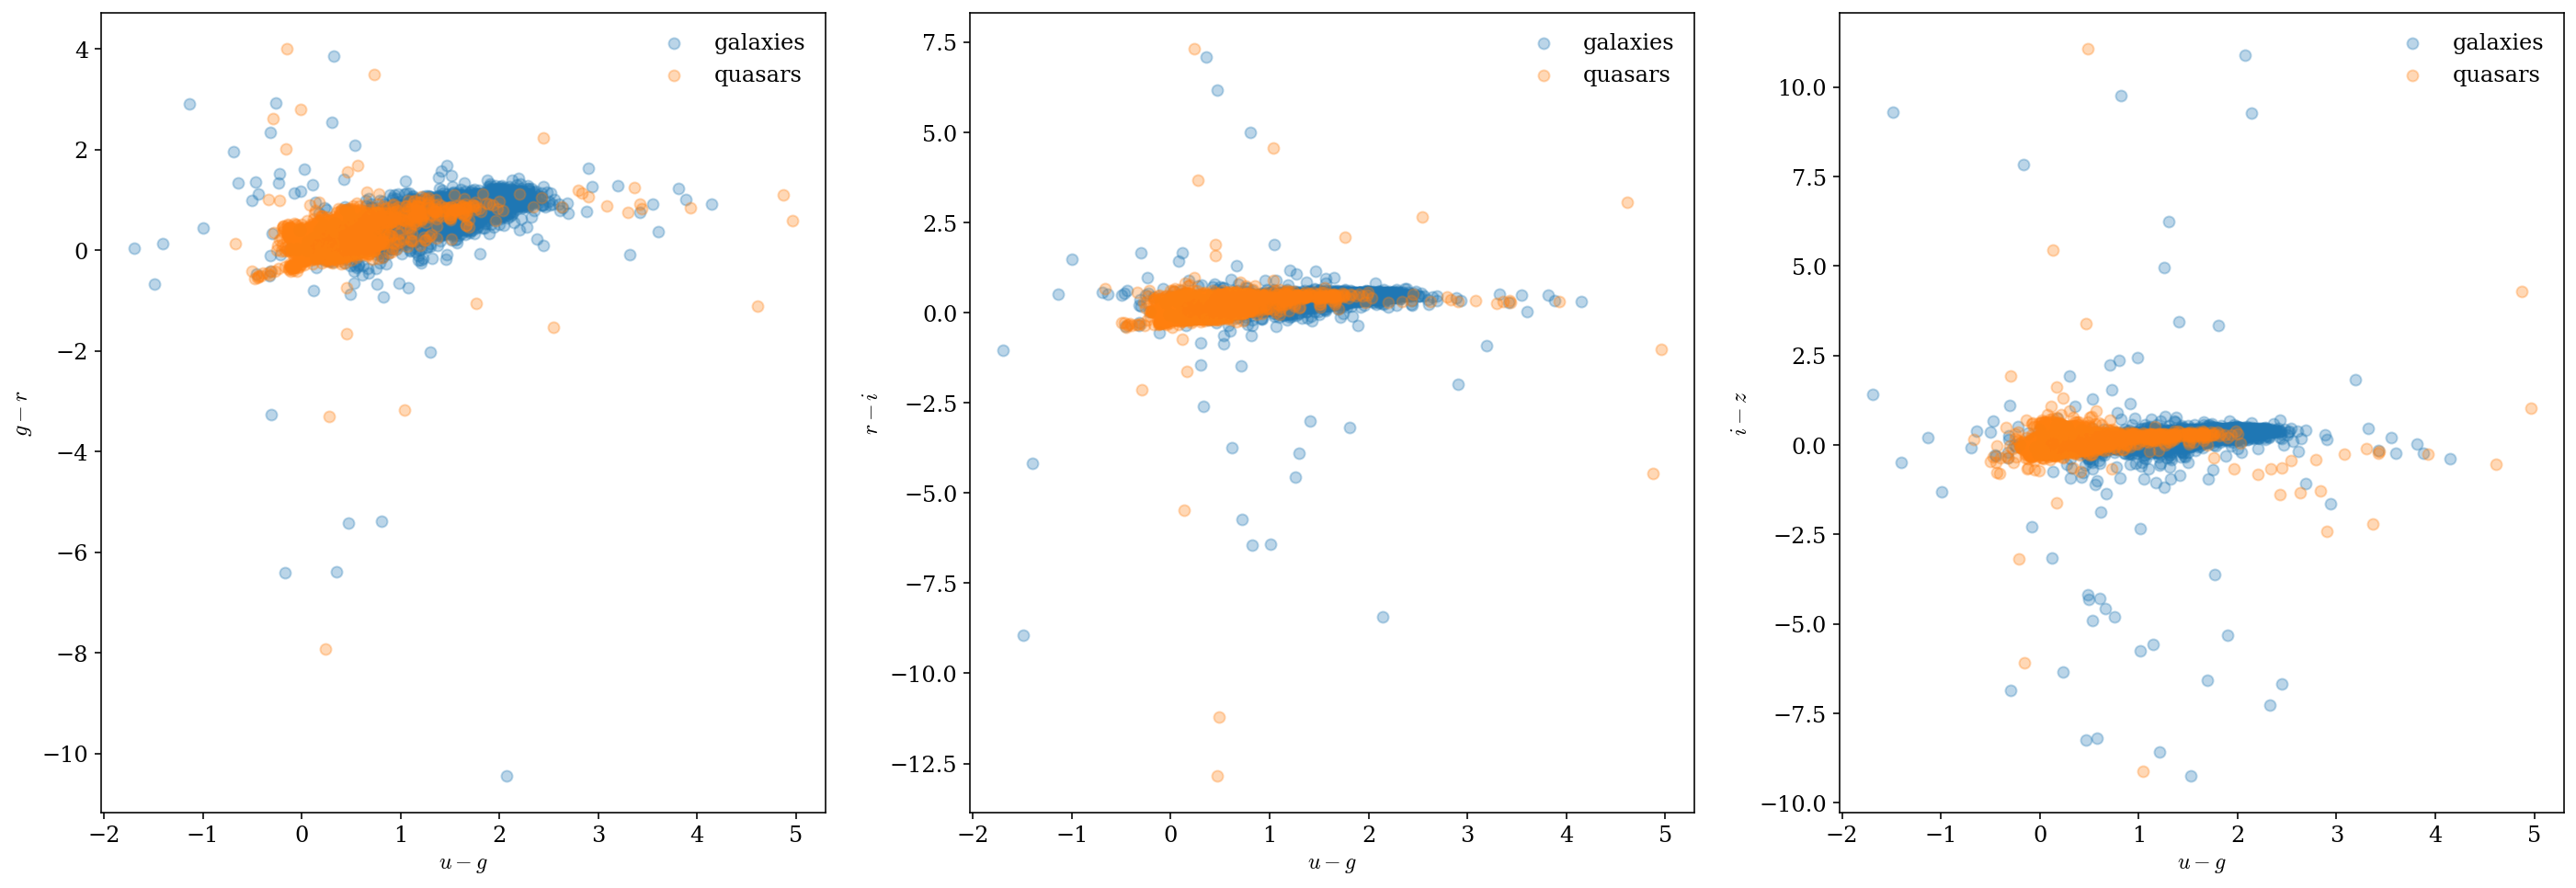

In [57]:
fig, axs = plt.subplots(1,3, figsize = (24,8))

axs[0].scatter(ug_train[labels_train == 0], gr_train[labels_train == 0], alpha=0.3, label='galaxies')
axs[0].scatter(ug_train[labels_train == 1], gr_train[labels_train == 1], alpha=0.3, label='quasars')
axs[0].set_xlabel(r'$u-g$') 
axs[0].set_ylabel(r'$g-r$')
axs[0].legend(frameon = False)

axs[1].scatter(ug_train[labels_train == 0], ri_train[labels_train == 0], alpha=0.3, label='galaxies')
axs[1].scatter(ug_train[labels_train == 1], ri_train[labels_train == 1], alpha=0.3, label='quasars')
axs[1].set_xlabel(r'$u-g$') 
axs[1].set_ylabel(r'$r-i$')
axs[1].legend(frameon = False)

axs[2].scatter(ug_train[labels_train == 0], iz_train[labels_train == 0], alpha=0.3, label='galaxies')
axs[2].scatter(ug_train[labels_train == 1], iz_train[labels_train == 1], alpha=0.3, label='quasars')
axs[2].set_xlabel(r'$u-g$') 
axs[2].set_ylabel(r'$i-z$')
axs[2].legend(frameon = False)

plt.show()

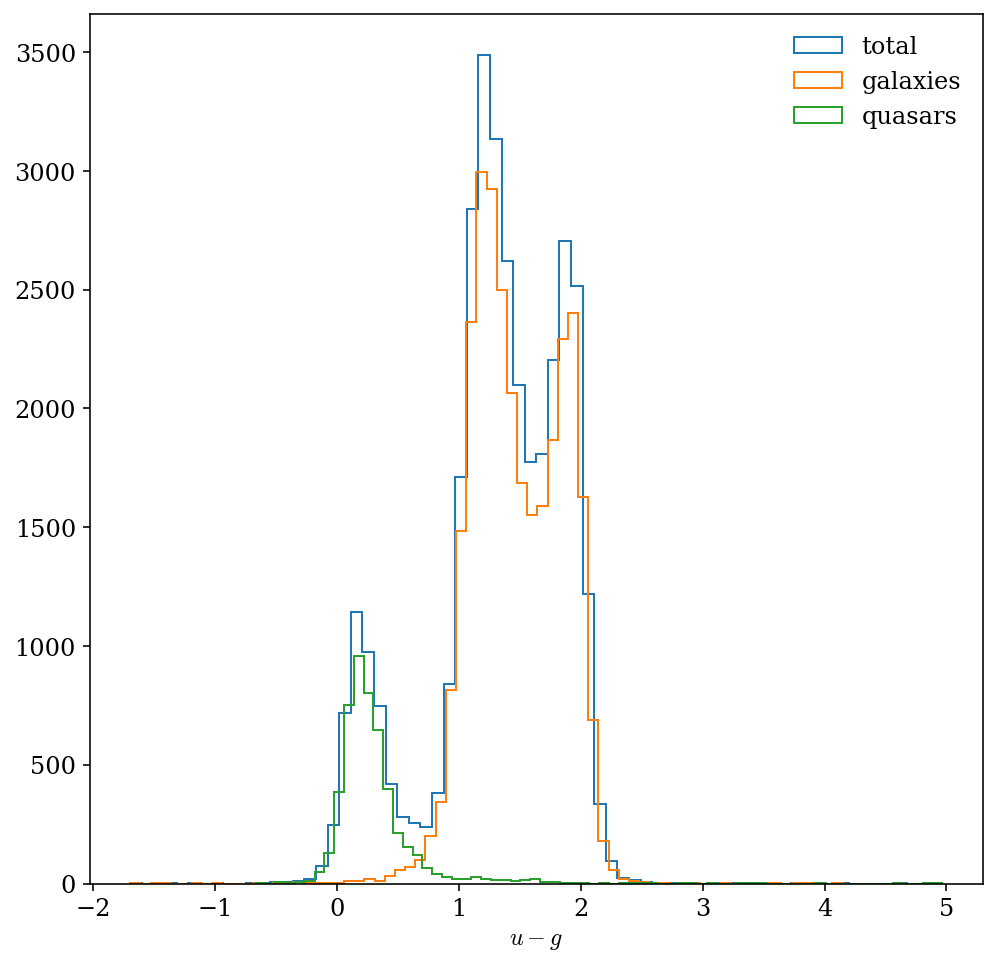

In [58]:
plt.hist(ug_train, bins = 70, histtype = 'step', label='total')
plt.hist(ug_train[labels_train == 0], bins = 70, histtype = 'step', label='galaxies')
plt.hist(ug_train[labels_train == 1], bins = 70, histtype = 'step', label='quasars')

plt.xlabel(r'$u-g$')
plt.legend(frameon = False)
plt.show()

## Classification

In [59]:
def return_accuracy(pred, test):
    true = len(pred[pred == test])
    return true / len(test)

In [60]:
accuracy = [] #best accuracy for each classifier
best_N = [] #number @ which the best accuracy is achieved 

### Gaussian naive bayes

In [61]:
classifiers, labels_pred, labels_proba = [], [], []
N = colors_train.shape[1] + 1
for n in range(1, N): #try with different colors
    X_train = colors_train[:,0:n]
    X_test = colors_test[:,0:n]

    clf = GaussianNB()
    clf.fit(X_train, labels_train)

    classifiers.append(clf)

    labels_pred.append(clf.predict(X_test))
    labels_proba.append(clf.predict_proba(X_test)[:,1])

In [62]:
# Compute the decision boundary
clf = classifiers[1] #2 colors
xlim = (min(X_train[:,0]), max(X_train[:,0]))
ylim = (min(X_train[:,1]), max(X_train[:,1]))

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

In [63]:
# ROC curve
fpr_list, tpr_list, thresh_list = [], [], []

for proba in labels_proba:
    fpr, tpr, thresh = roc_curve(labels_test, proba) #false and true positive rate + treshold
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    thresh_list.append(thresh)

In [64]:
#contamination and completeness
completeness, contamination = completeness_contamination(labels_pred, labels_test)
print('completeness: ', completeness)
print('contamination: ', contamination)

completeness:  [0.92886836 0.92933025 0.92886836 0.92655889]
contamination:  [0.06465116 0.10696849 0.10463045 0.1108156 ]


In [65]:
#accuracy
accuracy_NB = []
for pred in labels_pred:
    acc = return_accuracy(pred, labels_test)
    accuracy_NB.append(acc)
accuracy.append(max(accuracy_NB))
best_N.append(range(1,len(labels_pred)+1)[np.argmax(accuracy_NB)])

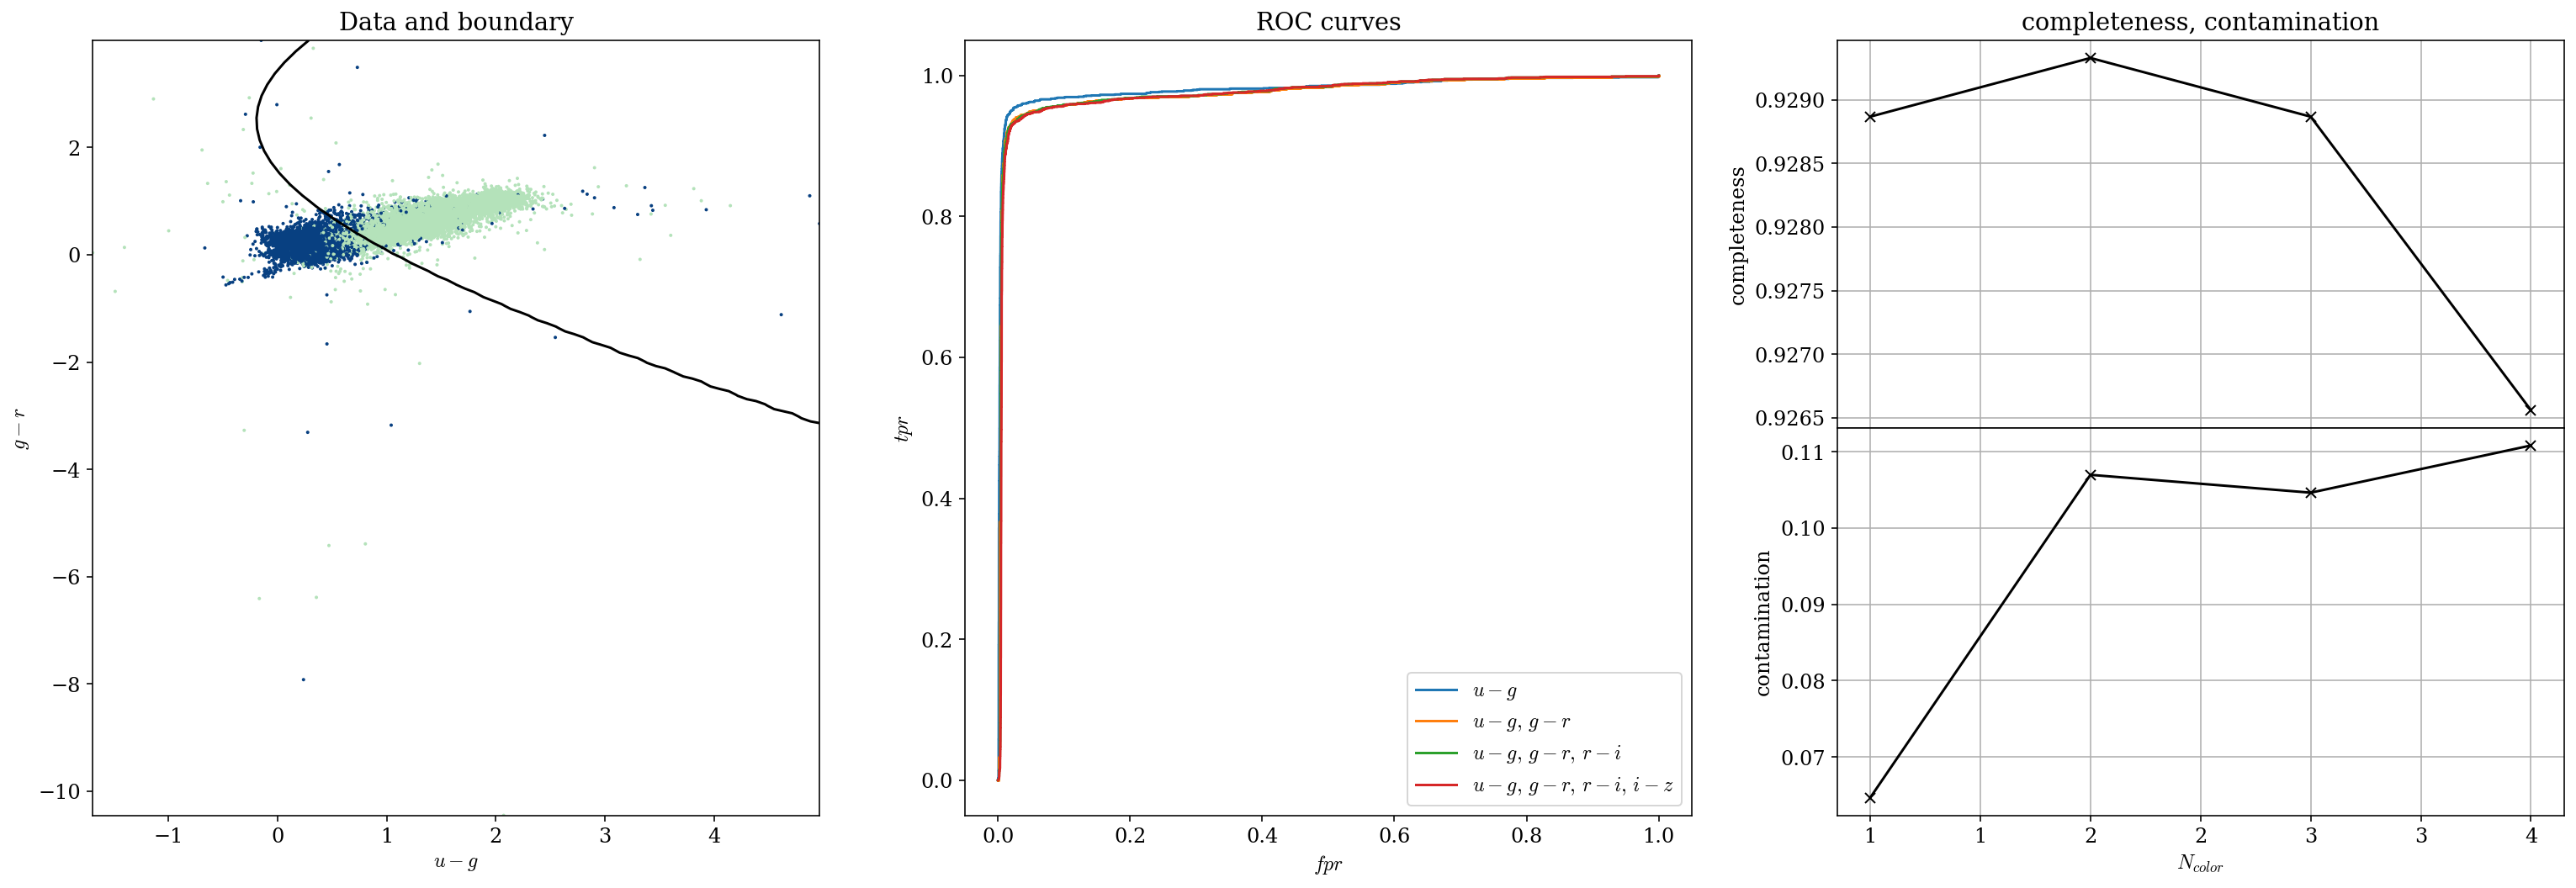

In [66]:
fig = plt.figure(figsize=(24, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)
ax1 = plt.subplot(131) #data: u-g vs g-r
ax2 = plt.subplot(132) #roc curves
ax3 = plt.subplot(233) #completeness
ax4 = plt.subplot(236) #contamination
#------------------------------------------------------------
im = ax1.scatter(X_train[:, 0], X_train[:, 1], c=labels_train,
                s=4, lw=0, cmap=plt.cm.GnBu, zorder=2)
im.set_clim(-0.5, 1)

ax1.contour(xx, yy, Z, [0.5], colors='k')

ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

ax1.set_xlabel(r'$u-g$')
ax1.set_ylabel(r'$g-r$')
ax1.set_title('Data and boundary')
#------------------------------------------------------------
labels_plot = [r'$u-g$', r'$u-g, \,g-r$', r'$u-g, \,g-r, \,r-i$', r'$u-g, \,g-r, \,r-i, \,i-z$']
for fpr, tpr, label in zip(fpr_list, tpr_list, labels_plot):
    ax2.plot(fpr, tpr, label = label)
    ax2.legend()
    
ax2.set_xlabel(r'$fpr$')
ax2.set_ylabel(r'$tpr$')
ax2.set_title('ROC curves')
#------------------------------------------------------------
ax3.plot(range(1,N), completeness, 'x-k')
ax3.set_ylabel('completeness')
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.set_title('completeness, contamination')
ax3.grid(True)
#------------------------------------------------------------
ax4.plot(range(1,N), contamination, 'x-k')
ax4.set_xlabel(r'$N_{color}$')
ax4.set_ylabel('contamination')
ax4.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax4.grid(True)
#------------------------------------------------------------
plt.show()

**$u-g$ is the most important feature** (as expected from the corner plot, it's the only color with a relevant variability)

### GMM Bayes

classifiers, labels_pred, labels_proba = [], [], []
N = colors_train.shape[1] + 1

comp_range = np.arange(1,5) #CV

for n in range(1, N): #try with different colors
    X_train = colors_train[:,0:n]
    X_test = colors_test[:,0:n]
    
    grid = GridSearchCV(GMMBayes(), {'n_components': comp_range}, cv=5)
    grid.fit(X_train, labels_train)
    n_opt = grid.best_params_['n_components']

    clf = GMMBayes(n_opt)
    clf.fit(X_train, labels_train)

    classifiers.append(clf)

    labels_pred.append(clf.predict(X_test))
    labels_proba.append(clf.predict_proba(X_test)[:,1])

In [67]:
classifiers, labels_pred, labels_proba = [], [], []
N = colors_train.shape[1] + 1

for n in range(1, N): #try with different colors
    X_train = colors_train[:,0:n]
    X_test = colors_test[:,0:n]
    
    clf = GMMBayes(5)
    clf.fit(X_train, labels_train)

    classifiers.append(clf)

    labels_pred.append(clf.predict(X_test))
    labels_proba.append(clf.predict_proba(X_test)[:,1])

In [68]:
# Compute the decision boundary
clf = classifiers[1] #2 colors
xlim = (min(X_train[:,0]), max(X_train[:,0]))
ylim = (min(X_train[:,1]), max(X_train[:,1]))

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

In [69]:
# ROC curve
fpr_list, tpr_list, thresh_list = [], [], []

for proba in labels_proba:
    fpr, tpr, thresh = roc_curve(labels_test, proba) #false and true positive rate + treshold
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    thresh_list.append(thresh)

In [70]:
#contamination and completeness
completeness, contamination = completeness_contamination(labels_pred, labels_test)
print('completeness: ', completeness)
print('contamination: ', contamination)

completeness:  [0.93487298 0.93718245 0.92979215 0.93163972]
contamination:  [0.07283555 0.06926606 0.04867675 0.04498106]


In [71]:
#accuracy
accuracy_GMM = []
for pred in labels_pred:
    acc = return_accuracy(pred, labels_test)
    accuracy_GMM.append(acc)
accuracy.append(max(accuracy_GMM))
best_N.append(range(1,len(labels_pred)+1)[np.argmax(accuracy_GMM)])

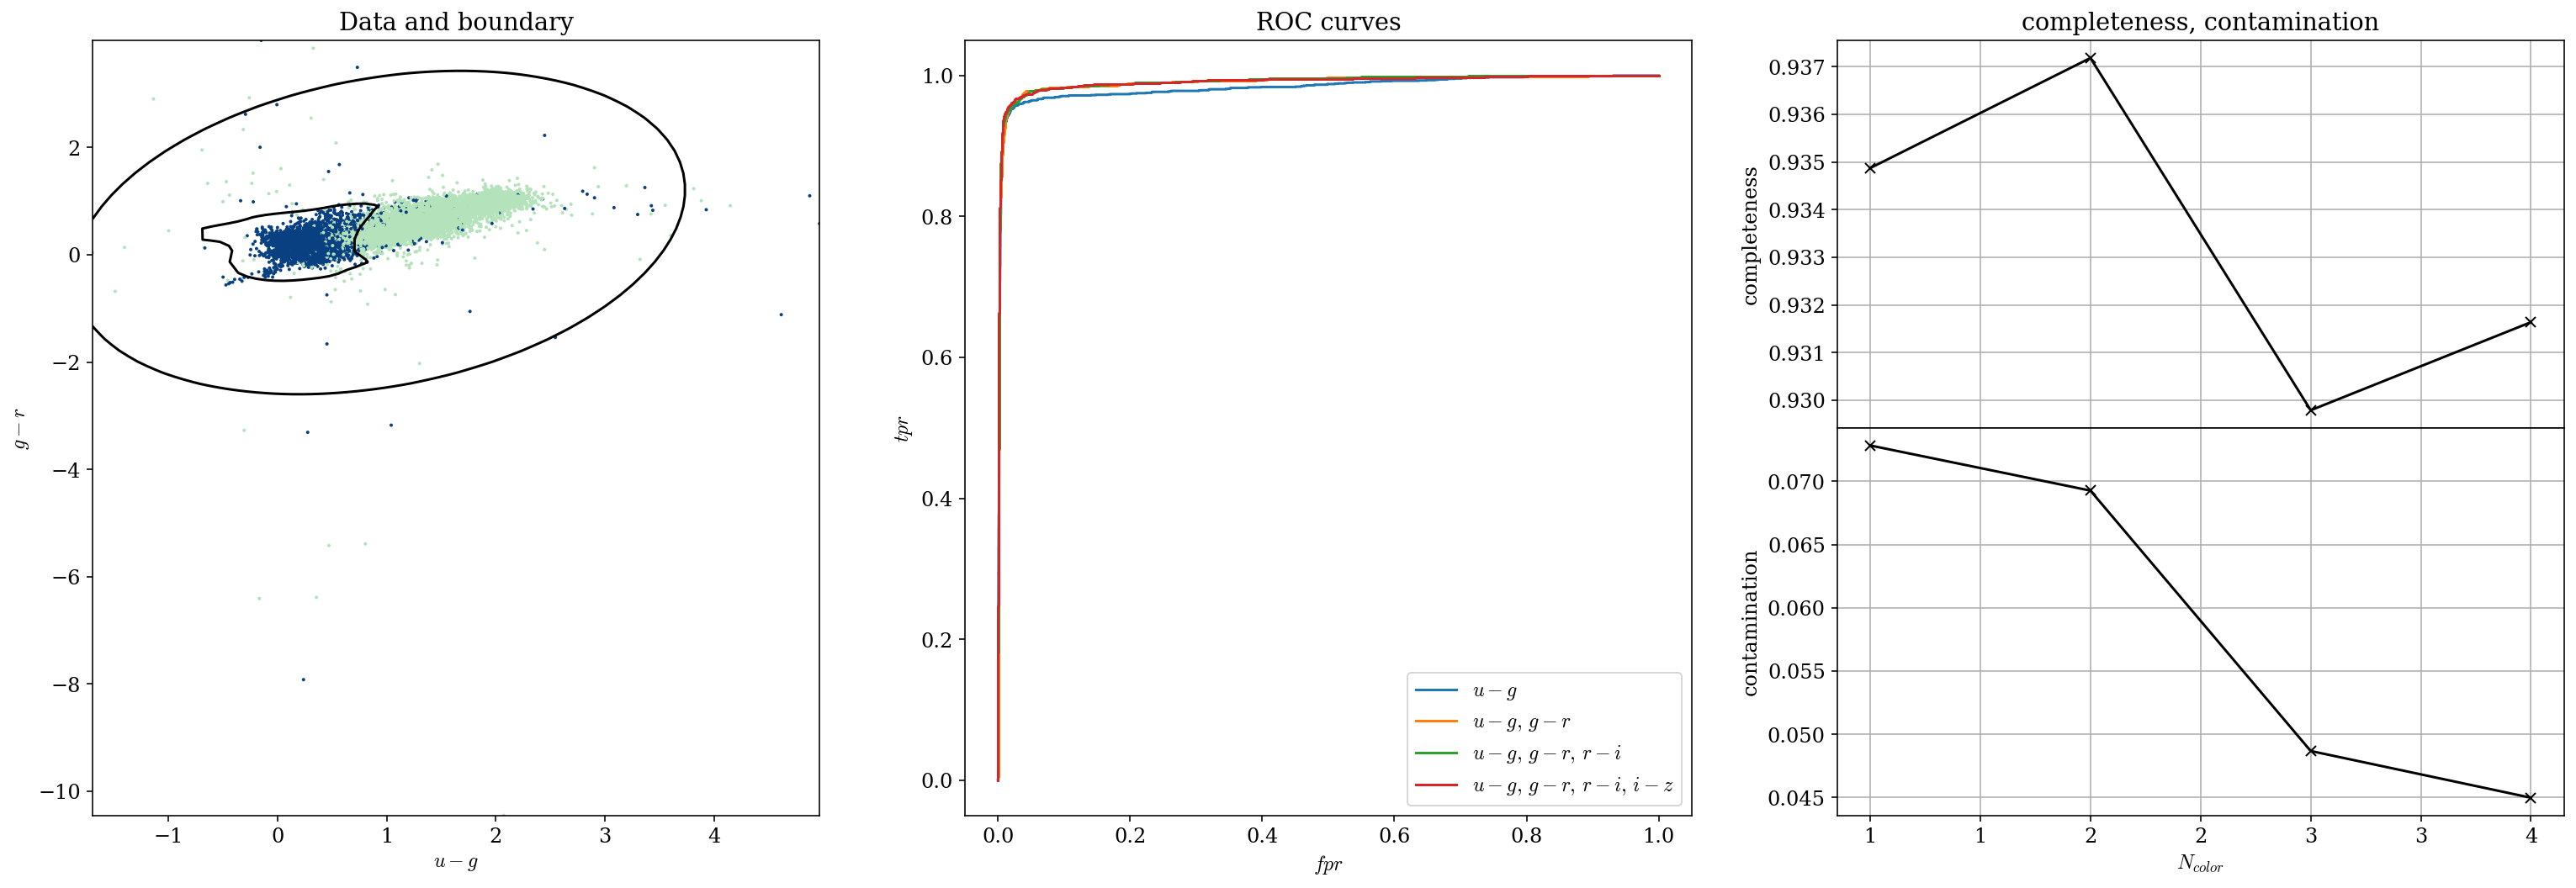

In [72]:
fig = plt.figure(figsize=(24, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)
ax1 = plt.subplot(131) #data: u-g vs g-r
ax2 = plt.subplot(132) #roc curves
ax3 = plt.subplot(233) #completeness
ax4 = plt.subplot(236) #contamination
#------------------------------------------------------------
im = ax1.scatter(X_train[:, 0], X_train[:, 1], c=labels_train,
                s=4, lw=0, cmap=plt.cm.GnBu, zorder=2)
im.set_clim(-0.5, 1)

ax1.contour(xx, yy, Z, [0.5], colors='k')

ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

ax1.set_xlabel(r'$u-g$')
ax1.set_ylabel(r'$g-r$')
ax1.set_title('Data and boundary')
#------------------------------------------------------------
labels_plot = [r'$u-g$', r'$u-g, \,g-r$', r'$u-g, \,g-r, \,r-i$', r'$u-g, \,g-r, \,r-i, \,i-z$']
for fpr, tpr, label in zip(fpr_list, tpr_list, labels_plot):
    ax2.plot(fpr, tpr, label = label)
    ax2.legend()
    
ax2.set_xlabel(r'$fpr$')
ax2.set_ylabel(r'$tpr$')
ax2.set_title('ROC curves')
#------------------------------------------------------------
ax3.plot(range(1,N), completeness, 'x-k')
ax3.set_ylabel('completeness')
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.set_title('completeness, contamination')
ax3.grid(True)
#------------------------------------------------------------
ax4.plot(range(1,N), contamination, 'x-k')
ax4.set_xlabel(r'$N_{color}$')
ax4.set_ylabel('contamination')
ax4.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax4.grid(True)
#------------------------------------------------------------
plt.show()

### K-Nearest Neighbor

In [73]:
def CV(X_train, labels_train, kvals):
    grid = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': kvals}, cv = 5)
    grid.fit(X_train, labels_train)
    best_k = grid.best_params_['n_neighbors']
    return best_k

In [74]:
classifiers, labels_pred, labels_proba = [], [], []
N = colors_train.shape[1] + 1
kvals = np.arange(1,15)
k_used = []
for n in range(1, N): #try with different colors
    X_train = colors_train[:,0:n]
    X_test = colors_test[:,0:n]
    #-- CV
    best_k = CV(X_train, labels_train, kvals)
    print(best_k)
    k_used.append(best_k)
    #–-
    clf = KNeighborsClassifier(n_neighbors = best_k)
    clf.fit(X_train, labels_train)

    classifiers.append(clf)

    labels_pred.append(clf.predict(X_test))
    labels_proba.append(clf.predict_proba(X_test)[:,1])

7
13
14
14


In [75]:
# Compute the decision boundary
clf = classifiers[1] #2 colors
xlim = (min(X_train[:,0]), max(X_train[:,0]))
ylim = (min(X_train[:,1]), max(X_train[:,1]))

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

In [76]:
# ROC curve
fpr_list, tpr_list, thresh_list = [], [], []

for proba in labels_proba:
    fpr, tpr, thresh = roc_curve(labels_test, proba)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    thresh_list.append(thresh)

In [77]:
#contamination and completeness
completeness, contamination = completeness_contamination(labels_pred, labels_test)
print('completeness: ', completeness)
print('contamination: ', contamination)

completeness:  [0.91778291 0.92424942 0.92886836 0.93487298]
contamination:  [0.06007569 0.05210801 0.04420152 0.04030346]


In [78]:
#accuracy
accuracy_k = []
for pred in labels_pred:
    acc = return_accuracy(pred, labels_test)
    accuracy_k.append(acc)
accuracy.append(max(accuracy_k))
best_N.append(range(1,len(labels_pred) + 1)[np.argmax(accuracy_k)])

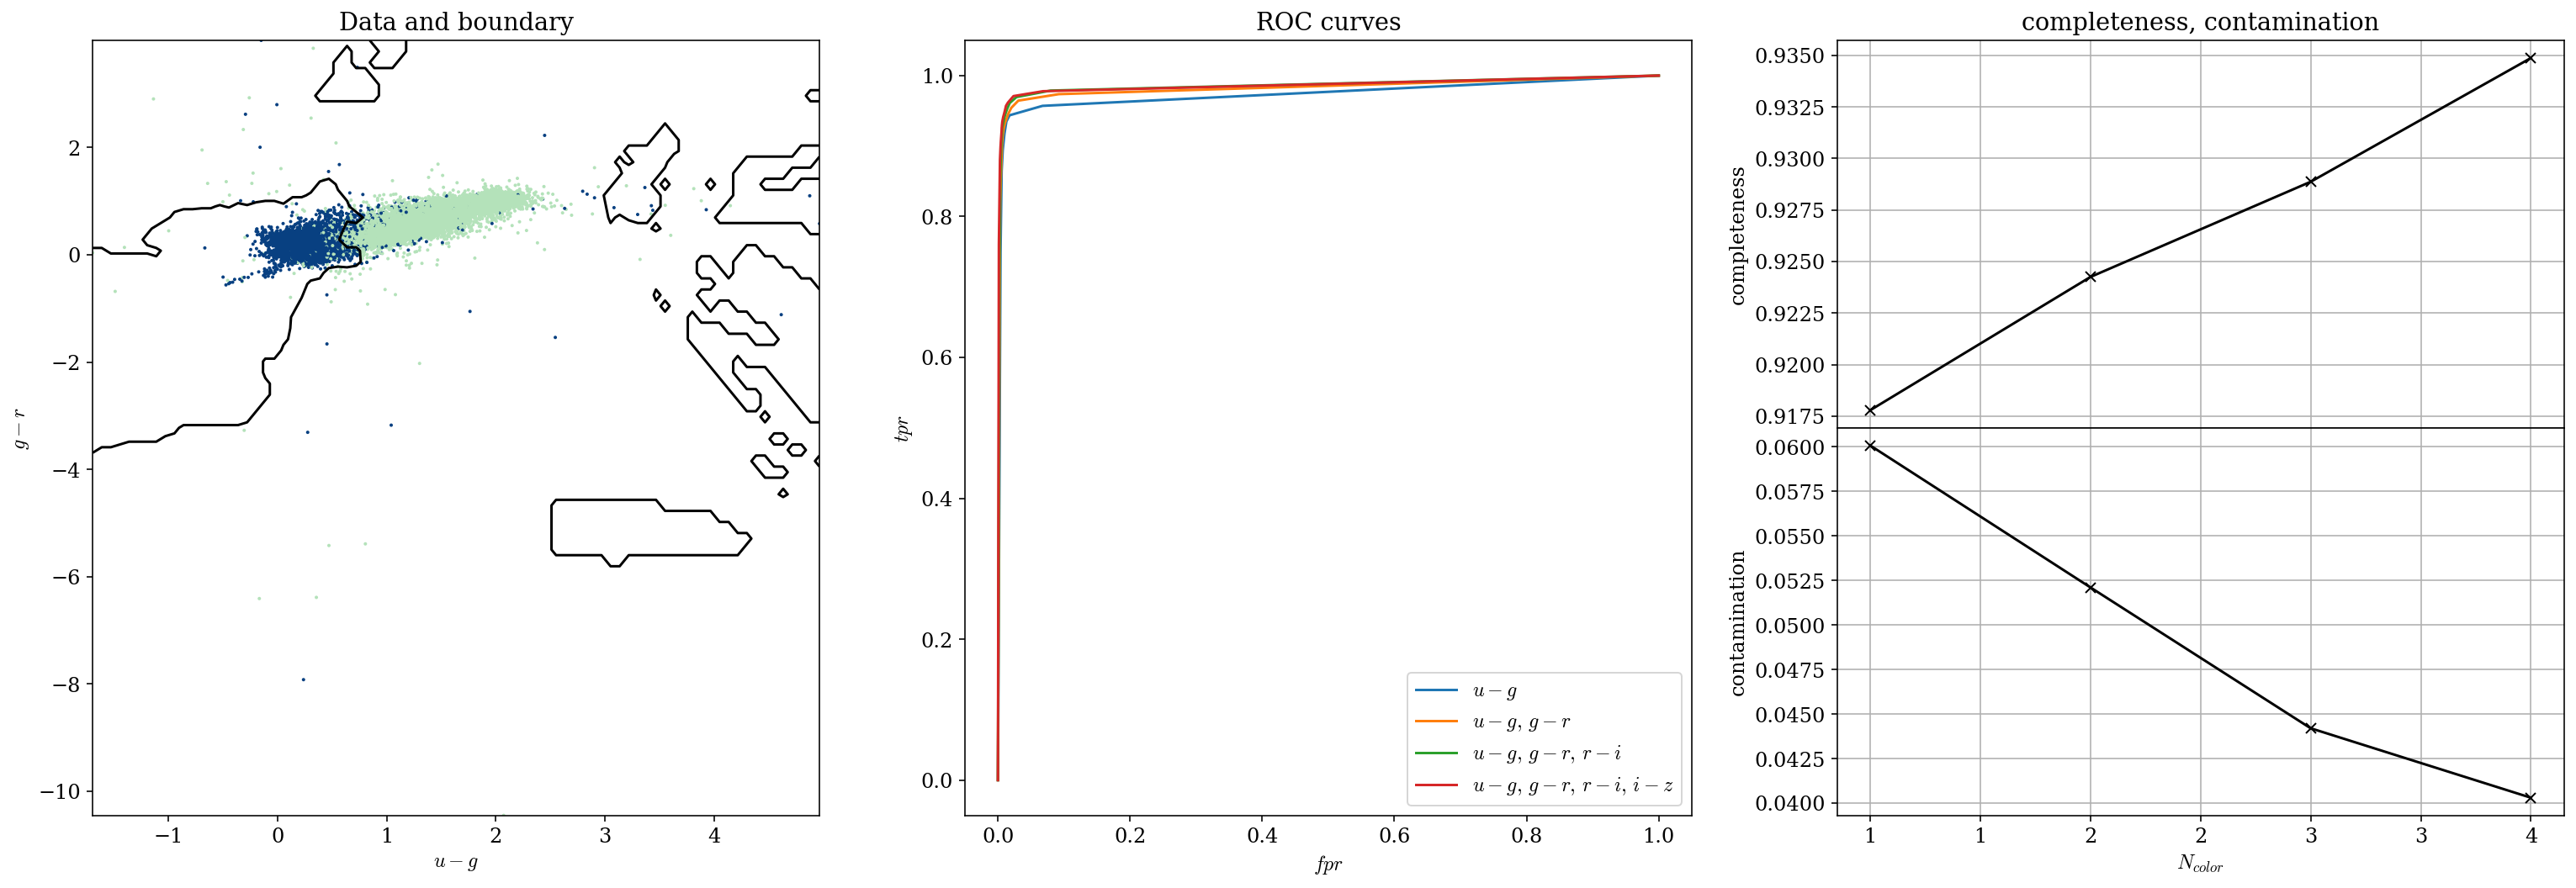

In [79]:
fig = plt.figure(figsize=(24, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)
ax1 = plt.subplot(131) #data: u-g vs g-r
ax2 = plt.subplot(132) #roc curves
ax3 = plt.subplot(233) #completeness
ax4 = plt.subplot(236) #contamination
#------------------------------------------------------------
im = ax1.scatter(X_train[:, 0], X_train[:, 1], c=labels_train,
                s=4, lw=0, cmap=plt.cm.GnBu, zorder=2)
im.set_clim(-0.5, 1)

ax1.contour(xx, yy, Z, [0.5], colors='k')

ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

ax1.set_xlabel(r'$u-g$')
ax1.set_ylabel(r'$g-r$')
ax1.set_title('Data and boundary')
#------------------------------------------------------------
labels_plot = [r'$u-g$', r'$u-g, \,g-r$', r'$u-g, \,g-r, \,r-i$', r'$u-g, \,g-r, \,r-i, \,i-z$']
for fpr, tpr, label in zip(fpr_list, tpr_list, labels_plot):
    ax2.plot(fpr, tpr, label = label)
    ax2.legend()
    
ax2.set_xlabel(r'$fpr$')
ax2.set_ylabel(r'$tpr$')
ax2.set_title('ROC curves')
#------------------------------------------------------------
ax3.plot(range(1,N), completeness, 'x-k')
ax3.set_ylabel('completeness')
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.set_title('completeness, contamination')
ax3.grid(True)
#------------------------------------------------------------
ax4.plot(range(1,N), contamination, 'x-k')
ax4.set_xlabel(r'$N_{color}$')
ax4.set_ylabel('contamination')
ax4.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax4.grid(True)
#------------------------------------------------------------
plt.show()

In [80]:
print('The cross validated numbers of neighbors are: ')
for i, k in enumerate(k_used):
    i+=1
    if i == 1:
        print('%i for %i color' % (k,i))
    else:
        print('%i for %i colors' % (k,i))

The cross validated numbers of neighbors are: 
7 for 1 color
13 for 2 colors
14 for 3 colors
14 for 4 colors


In [81]:
methods = ['Gaussian naive bayes', 'GMM Bayes', 'K-Nearest Neighbor']
for name, acc, n in zip(methods, accuracy, best_N):
    print(name + ': accuracy = %.4f for Ncolors = %i' % (acc, n))

Gaussian naive bayes: accuracy = 0.9805 for Ncolors = 1
GMM Bayes: accuracy = 0.9838 for Ncolors = 4
K-Nearest Neighbor: accuracy = 0.9849 for Ncolors = 4


### -----

## TensorFlow  
use all the colors

In [82]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import os
from time import time

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [83]:
#clean the log directory
#uncomment the right one
#clean = True
clean = False
if clean == True:
    !rm -rf ./logs/
    !rm -rf ./logsL19_trained/

    #trained model
    !rm -rf ./L19_trained.h5

In [93]:
layers_list = [1,2]
neurons_list = np.arange(2, 2*len(colors_train[0]) + 1).tolist()
lr_list = np.linspace(1e-3, 1e-1, 10).tolist()
act_list = ['relu', 'tanh']

In [84]:
#hyperparameters: CV the number of neurons, the activation function and the lr
HP_NUM_LAYERS = hp.HParam('num_layers', hp.Discrete(layers_list))
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete(neurons_list))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete(neurons_list))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete(lr_list))
HP_ACT_FUNCTION_1 = hp.HParam('activation_1', hp.Discrete(act_list))
HP_ACT_FUNCTION_2 = hp.HParam('activation_2', hp.Discrete(act_list))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/L19_hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_LAYERS, HP_NUM_UNITS_1, HP_NUM_UNITS_2, HP_LEARNING_RATE, HP_ACT_FUNCTION_1, HP_ACT_FUNCTION_2],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [85]:
#functions
#---
def rescale_colors(colors):
    rescaled_colors = np.zeros_like(colors)
    for i in range(len(colors[0])):
        lims = min(colors[:,i]), max(colors[:,i])
        rescaled_colors[:,i] = 1 - 2 * (colors[:, i] - lims[0]) / (lims[1] - lims[0])
    return rescaled_colors
#---
#CV for the hyperparams
def train_test_model(colors_train, labels_train, colors_test, labels_test, hparams):

    train_in  = rescale_colors(colors_train)
    train_out = labels_train
    test_in  = rescale_colors(colors_test)
    test_out = labels_test

    # Kernel initializer
    my_init = tf.keras.initializers.glorot_uniform(seed=1)
    # Define neural network architecture
    model = tf.keras.Sequential([
        # Input layer, do not change
        tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
        # Inner layers, can add/change
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS_1], activation=hparams[HP_ACT_FUNCTION_1], kernel_initializer=my_init),
        ])
    
    #eventual second layer
    if HP_NUM_LAYERS == 2:
        model.add(tf.keras.layers.Dense(hparams[HP_NUM_UNITS_2], activation=hparams[HP_ACT_FUNCTION_2], kernel_initializer=my_init))
    
    #output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid',kernel_initializer=my_init))
    
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE]),
        loss = 'binary_crossentropy',
        metrics=['accuracy'])

    model.fit(colors_train, labels_train, epochs=5) 
    _, accuracy = model.evaluate(colors_test, labels_test)
    return accuracy
#---
def run(run_dir, colors_train, labels_train, colors_test, labels_test, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(colors_train, labels_train, colors_test, labels_test, hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
    return accuracy
#---
def trainnetwork(colors_train, labels_train, colors_test, labels_test, hparams, filename='L19_trained.h5'):

    if not os.path.isfile(filename):

        train_in  = rescale_colors(colors_train)
        train_out = labels_train
        test_in  = rescale_colors(colors_test)
        test_out = labels_test

        # Kernel initializer
        my_init = tf.keras.initializers.glorot_uniform(seed=1)
        # Define neural network architecture
        model = tf.keras.Sequential([
            # Input layer, do not change
            tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
            # Inner layers, can add/change
            tf.keras.layers.Dense(hparams[HP_NUM_UNITS_1], activation=hparams[HP_ACT_FUNCTION_1], kernel_initializer=my_init),
            ])
    
         #eventual second layer
        if HP_NUM_LAYERS == 2:
            model.add(tf.keras.layers.Dense(hparams[HP_NUM_UNITS_2], activation=hparams[HP_ACT_FUNCTION_2], kernel_initializer=my_init))
    
        #output layer
        model.add(tf.keras.layers.Dense(1, activation='sigmoid',kernel_initializer=my_init))
    
        model.compile(
            # Optimization algorithm
            optimizer = tf.keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE]),
            # Loss function for a binary classifier
            loss='binary_crossentropy',
            # Diagnostic quantities
            metrics=['accuracy'])

        # Decrease the learning rate exponentially after the first 10 epochs
        def scheduler(epoch, lr):
            if epoch < 10:
                return lr
            else:
                return lr * tf.math.exp(-0.05)

        # Actual Training
        history = model.fit(
            # Training inputs
            train_in,
            # Training outputs
            train_out,
            # Evaluate test set at each epoch
            validation_data=(test_in, test_out),
            # Batch size, default is 32
            #batch_size=32,
            # Number of epochs
            epochs=150,
            # Store the model with the best validation accuracy
            callbacks = [
                # Drecrease learning rate
                tf.keras.callbacks.LearningRateScheduler(scheduler),
                # Store the model with the best validation accuracy
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
                # Save logfiles for tensorboard
                tf.keras.callbacks.TensorBoard(log_dir="logs"+filename.split('.h5')[0], histogram_freq=1)],
            # Shuffle data at each epoch
            shuffle=True)

    model = loadnetwork(filename)
    return model
#---
def loadnetwork(filename,verbose=False):
    '''
    Load a trained neural network
    '''

    model = tf.keras.models.load_model(filename)
    if verbose:
        model.summary()

    return model
#---
def testnetwork(model, colors_test, labels_test):
    '''
    Test network 
    '''
    test_in  = rescale_colors(colors_test)
    test_out = labels_test
    model.evaluate(test_in,  test_out, verbose=2)
#---
def predictnetwork(model, colors_test):
    '''
    Use a network to predict the class.
    '''
    # Return the class (0 or 1) that is preferred
    predictions = np.squeeze((model.predict(rescale_colors(colors_test)) > 0.5).astype("int32"))
    return predictions

In [86]:
#trained file:
filename='L19_trained.h5'

how much does the CV on a grid take? 

In [87]:
hparams = {
            HP_NUM_LAYERS: 0,
            HP_NUM_UNITS_1: 0,
            HP_NUM_UNITS_2: 0,
            HP_LEARNING_RATE: 0,
            HP_ACT_FUNCTION_1: 0,
            HP_ACT_FUNCTION_2: 0
        }
#VALIDATION
if not os.path.isfile(filename):
    tmp = time()
    accuracy_best = 0
    session_num = 0

    for num_layers in HP_NUM_LAYERS.domain.values:
        for num_units_1 in HP_NUM_UNITS_1.domain.values:
            for lr in HP_LEARNING_RATE.domain.values:
                for activation_1 in HP_ACT_FUNCTION_1.domain.values:
                    if num_layers == 1:
                        hparams = {
                                    HP_NUM_LAYERS: num_layers,
                                    HP_NUM_UNITS_1: num_units_1,
                                    HP_NUM_UNITS_2: 0,
                                    HP_LEARNING_RATE: lr,
                                    HP_ACT_FUNCTION_1: activation_1,
                                    HP_ACT_FUNCTION_2: 0
                                    }
                        run_name = "run-%d" % session_num
                        print('--- Starting trial: %s' % run_name)
                        print({h.name: hparams[h] for h in hparams})
                        accuracy_try = run('logs/hparam_tuning/' + run_name, colors_train, labels_train, colors_test, labels_test, hparams)
                        session_num += 1
        
                        if accuracy_try > accuracy_best:
                            accuracy_best = accuracy_try
                                    
                            best_num_layers = num_layers
                            best_num_units_1 = num_units_1
                            best_num_units_2 = 0
                            best_lr = lr
                            best_activation_1 = activation_1
                            best_activation_2 = 0
                            
                    elif num_layers == 2:
                        for num_units_2 in HP_NUM_UNITS_2.domain.values:
                            for activation_2 in HP_ACT_FUNCTION_2.domain.values:
                                hparams = {
                                            HP_NUM_LAYERS: num_layers,
                                            HP_NUM_UNITS_1: num_units_1,
                                            HP_NUM_UNITS_2: num_units_2,
                                            HP_LEARNING_RATE: lr,
                                            HP_ACT_FUNCTION_1: activation_1,
                                            HP_ACT_FUNCTION_2: activation_2
                                    }
                                run_name = "run-%d" % session_num
                                print('--- Starting trial: %s' % run_name)
                                print({h.name: hparams[h] for h in hparams})
                                accuracy_try = run('logs/hparam_tuning/' + run_name, colors_train, labels_train, colors_test, labels_test, hparams)
                                session_num += 1
        
                                if accuracy_try > accuracy_best:
                                    accuracy_best = accuracy_try
                                    
                                    best_num_layers = num_layers
                                    best_num_units_1 = num_units_1
                                    best_num_units_2 = num_units_2
                                    best_lr = lr
                                    best_activation_1 = activation_1
                                    best_activation_2 = activation_2
            
    hparams = {
            HP_NUM_LAYERS: best_num_layers,
            HP_NUM_UNITS_1: best_num_units_1,
            HP_NUM_UNITS_2: best_num_units_2,
            HP_LEARNING_RATE: best_lr,
            HP_ACT_FUNCTION_1: best_activation_1,
            HP_ACT_FUNCTION_2: best_activation_2
        }
    print(hparams)
    print(accuracy_best)
    
    tmp = time() - tmp
    print('---- \nThe cross validation took %.2f s' % tmp)

--- Starting trial: run-0
{'num_layers': 1, 'num_units_1': 2, 'num_units_2': 0, 'learning_rate': 0.001, 'activation_1': 'relu', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.5893 - accuracy: 0.7482
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.4424 - accuracy: 0.8578
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.4124 - accuracy: 0.8579
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.3938 - accuracy: 0.8578
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.2012 - accuracy: 0.9641
--- Starting trial: run-1
{'num_layers': 1, 'num_units_1': 2, 'num_units_2': 0, 'learning_rate': 0.001, 'activation_1': 'tanh', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.5234 - accuracy: 0.7154
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2783 - accuracy: 0.8640
E

469/469 [==============================] - 1s 1ms/step - loss: 0.0843 - accuracy: 0.9813
--- Starting trial: run-11
{'num_layers': 1, 'num_units_1': 2, 'num_units_2': 0, 'learning_rate': 0.05600000000000001, 'activation_1': 'tanh', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0816 - accuracy: 0.9751
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0646 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0634 - accuracy: 0.9840
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0639 - accuracy: 0.9841
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0662 - accuracy: 0.9827
--- Starting trial: run-12
{'num_layers': 1, 'num_units_1': 2, 'num_units_2': 0, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0966 - accuracy: 0.97

469/469 [==============================] - 1s 1ms/step - loss: 0.0730 - accuracy: 0.9805
--- Starting trial: run-22
{'num_layers': 1, 'num_units_1': 3, 'num_units_2': 0, 'learning_rate': 0.012, 'activation_1': 'relu', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1105 - accuracy: 0.9626
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0780 - accuracy: 0.9816
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0769 - accuracy: 0.9818
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0764 - accuracy: 0.9818
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0843 - accuracy: 0.9815
--- Starting trial: run-23
{'num_layers': 1, 'num_units_1': 3, 'num_units_2': 0, 'learning_rate': 0.012, 'activation_1': 'tanh', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1074 - accuracy: 0.9617
Epoch 2/5
1

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0768 - accuracy: 0.9818
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0721 - accuracy: 0.9793
--- Starting trial: run-33
{'num_layers': 1, 'num_units_1': 3, 'num_units_2': 0, 'learning_rate': 0.067, 'activation_1': 'tanh', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0725 - accuracy: 0.9802
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0641 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0627 - accuracy: 0.9839
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0620 - accuracy: 0.9842
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0614 - accuracy: 0.9833
--- Starting trial: run-34
{'num_layers': 1, 'num_units_1': 3, 'num_units_2': 0, 'learning_rate': 0.07800000000000001, 'activation_1': 'relu', 'activation_2': 

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0635 - accuracy: 0.9840
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0622 - accuracy: 0.9843
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0626 - accuracy: 0.9831
--- Starting trial: run-44
{'num_layers': 1, 'num_units_1': 4, 'num_units_2': 0, 'learning_rate': 0.023000000000000003, 'activation_1': 'relu', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0897 - accuracy: 0.9768
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0713 - accuracy: 0.9822
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0701 - accuracy: 0.9831
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0696 - accuracy: 0.9836
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0660 - accuracy: 0.9831
--- Starting trial: run-45
{'num_layers': 1

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0834 - accuracy: 0.9813
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0783 - accuracy: 0.9805
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0730 - accuracy: 0.9811
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0717 - accuracy: 0.9805
--- Starting trial: run-55
{'num_layers': 1, 'num_units_1': 4, 'num_units_2': 0, 'learning_rate': 0.07800000000000001, 'activation_1': 'tanh', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0874 - accuracy: 0.9751
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0668 - accuracy: 0.9831
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0647 - accuracy: 0.9833
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0638 - accuracy: 0.9841
Epoch 5/5
469/469 [=======================

1094/1094 [==============================] - 3s 2ms/step - loss: 0.0798 - accuracy: 0.9774
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0625 - accuracy: 0.9840
Epoch 3/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0603 - accuracy: 0.9841
Epoch 4/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0592 - accuracy: 0.9843
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0572 - accuracy: 0.9833
--- Starting trial: run-66
{'num_layers': 1, 'num_units_1': 5, 'num_units_2': 0, 'learning_rate': 0.034, 'activation_1': 'relu', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0909 - accuracy: 0.9769
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0769 - accuracy: 0.9822
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0739 - accuracy: 0.9826
Epoch 4/5
1094/1094 [==============================] - 2

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0980 - accuracy: 0.9794
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0913 - accuracy: 0.9812
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0882 - accuracy: 0.9813
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0832 - accuracy: 0.9828
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0735 - accuracy: 0.9826
--- Starting trial: run-77
{'num_layers': 1, 'num_units_1': 5, 'num_units_2': 0, 'learning_rate': 0.08900000000000001, 'activation_1': 'tanh', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0775 - accuracy: 0.9789
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0630 - accuracy: 0.9839
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0633 - accuracy: 0.9841
Epoch 4/5
1094/1094 [===========

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0737 - accuracy: 0.9807
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0621 - accuracy: 0.9840
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0602 - accuracy: 0.9846
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0592 - accuracy: 0.9844
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0648 - accuracy: 0.9819
--- Starting trial: run-88
{'num_layers': 1, 'num_units_1': 6, 'num_units_2': 0, 'learning_rate': 0.045000000000000005, 'activation_1': 'relu', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0878 - accuracy: 0.9796
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0797 - accuracy: 0.9815
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0753 - accuracy: 0.9823
Epoch 4/5
1094/1094 [==========

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0964 - accuracy: 0.9774
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0841 - accuracy: 0.9816
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0837 - accuracy: 0.9818
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0796 - accuracy: 0.9805
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0829 - accuracy: 0.9791
--- Starting trial: run-99
{'num_layers': 1, 'num_units_1': 6, 'num_units_2': 0, 'learning_rate': 0.1, 'activation_1': 'tanh', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0726 - accuracy: 0.9813
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0644 - accuracy: 0.9832
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0629 - accuracy: 0.9835
Epoch 4/5
1094/1094 [===========================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0713 - accuracy: 0.9814
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0618 - accuracy: 0.9839
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0606 - accuracy: 0.9841
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0594 - accuracy: 0.9847
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0606 - accuracy: 0.9819
--- Starting trial: run-110
{'num_layers': 1, 'num_units_1': 7, 'num_units_2': 0, 'learning_rate': 0.05600000000000001, 'activation_1': 'relu', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0955 - accuracy: 0.9764
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0853 - accuracy: 0.9808
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0784 - accuracy: 0.9809
Epoch 4/5
1094/1094 [==========

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2724 - accuracy: 0.9541
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0884 - accuracy: 0.9810
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0789 - accuracy: 0.9813
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0770 - accuracy: 0.9818
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0795 - accuracy: 0.9801
--- Starting trial: run-121
{'num_layers': 1, 'num_units_1': 8, 'num_units_2': 0, 'learning_rate': 0.001, 'activation_1': 'tanh', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2822 - accuracy: 0.8623
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1046 - accuracy: 0.9749
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0794 - accuracy: 0.9803
Epoch 4/5
1094/1094 [========================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0732 - accuracy: 0.9810
Epoch 2/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0651 - accuracy: 0.9830
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0620 - accuracy: 0.9841
Epoch 4/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0601 - accuracy: 0.9844
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0559 - accuracy: 0.9835
--- Starting trial: run-132
{'num_layers': 1, 'num_units_1': 8, 'num_units_2': 0, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0884 - accuracy: 0.9795
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0760 - accuracy: 0.9816
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0779 - accuracy: 0.9823
Epoch 4/5
1094/1094 [========================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.5165 - accuracy: 0.9399
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2796 - accuracy: 0.9776
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1704 - accuracy: 0.9806
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1217 - accuracy: 0.9809
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0958 - accuracy: 0.9800
--- Starting trial: run-143
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 3, 'learning_rate': 0.001, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.9066 - accuracy: 0.5037
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.4601 - accuracy: 0.8575
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.4193 - accuracy: 0.8576
Epoch 4/5
1094/1094 [===================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.2579 - accuracy: 0.8613
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1646 - accuracy: 0.9390
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1255 - accuracy: 0.9709
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1076 - accuracy: 0.9768
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0967 - accuracy: 0.9781
--- Starting trial: run-154
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 2, 'learning_rate': 0.001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.2157 - accuracy: 0.9142
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1077 - accuracy: 0.9765
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0817 - accuracy: 0.9804
Epoch 4/5
1094/1094 [===================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.4379 - accuracy: 0.8046
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2439 - accuracy: 0.8955
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1373 - accuracy: 0.9655
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1007 - accuracy: 0.9748
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0846 - accuracy: 0.9776
--- Starting trial: run-165
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 7, 'learning_rate': 0.001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.2880 - accuracy: 0.8835
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1373 - accuracy: 0.9680
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0895 - accuracy: 0.9788
Epoch 4/5
1094/1094 [===================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1594 - accuracy: 0.9667
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0780 - accuracy: 0.9814
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0766 - accuracy: 0.9812
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0764 - accuracy: 0.9814
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0811 - accuracy: 0.9799
--- Starting trial: run-176
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 6, 'learning_rate': 0.012, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1041 - accuracy: 0.9699
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0781 - accuracy: 0.9822
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0773 - accuracy: 0.9816
Epoch 4/5
1094/1094 [===================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0941 - accuracy: 0.9736
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0667 - accuracy: 0.9837
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0640 - accuracy: 0.9836
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0629 - accuracy: 0.9839
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0615 - accuracy: 0.9833
--- Starting trial: run-187
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 4, 'learning_rate': 0.012, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1019 - accuracy: 0.9707
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0642 - accuracy: 0.9838
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0627 - accuracy: 0.9837
Epoch 4/5
1094/1094 [===================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1457 - accuracy: 0.9603
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0767 - accuracy: 0.9822
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0753 - accuracy: 0.9822
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0723 - accuracy: 0.9827
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0703 - accuracy: 0.9820
--- Starting trial: run-198
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 3, 'learning_rate': 0.023000000000000003, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.2855 - accuracy: 0.9099
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0740 - accuracy: 0.9825
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0701 - accuracy: 0.9829
Epoch 4/5
1094/1094 [====

469/469 [==============================] - 1s 1ms/step - loss: 0.0815 - accuracy: 0.9809
--- Starting trial: run-208
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 8, 'learning_rate': 0.023000000000000003, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.4215 - accuracy: 0.8509
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.4088 - accuracy: 0.8579
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1352 - accuracy: 0.9621
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0783 - accuracy: 0.9813
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0844 - accuracy: 0.9810
--- Starting trial: run-209
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 8, 'learning_rate': 0.023000000000000003, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - l

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0618 - accuracy: 0.9835
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0620 - accuracy: 0.9822
--- Starting trial: run-219
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 6, 'learning_rate': 0.023000000000000003, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1019 - accuracy: 0.9663
Epoch 2/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0672 - accuracy: 0.9829
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0652 - accuracy: 0.9837
Epoch 4/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0636 - accuracy: 0.9836
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0623 - accuracy: 0.9831
--- Starting trial: run-220
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 7, 'learning_rate': 0.023000000000000003, 'activation_1': '

1094/1094 [==============================] - 2s 2ms/step - loss: 0.4092 - accuracy: 0.8579
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.4093 - accuracy: 0.8580
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.4134 - accuracy: 0.8557
--- Starting trial: run-230
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 5, 'learning_rate': 0.034, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1410 - accuracy: 0.9565
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0780 - accuracy: 0.9809
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0776 - accuracy: 0.9814
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0773 - accuracy: 0.9822
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0677 - accuracy: 0.9819
--- Starting trial: run-231
{'num_layers': 2, 'num_u

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0646 - accuracy: 0.9837
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0633 - accuracy: 0.9837
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0630 - accuracy: 0.9840
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0629 - accuracy: 0.9839
--- Starting trial: run-241
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 3, 'learning_rate': 0.034, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0913 - accuracy: 0.9721
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0660 - accuracy: 0.9829
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0634 - accuracy: 0.9833
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0628 - accuracy: 0.9829
Epoch 5/5
469/469 [==============================]

1094/1094 [==============================] - 3s 2ms/step - loss: 0.0885 - accuracy: 0.9724
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0644 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0633 - accuracy: 0.9831
Epoch 4/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0630 - accuracy: 0.9835
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0677 - accuracy: 0.9813
--- Starting trial: run-252
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 2, 'learning_rate': 0.045000000000000005, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0986 - accuracy: 0.9765
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0875 - accuracy: 0.9818
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0847 - accuracy: 0.9821
Epoch 4/5
1094/1094 [==============

469/469 [==============================] - 2s 3ms/step - loss: 0.0817 - accuracy: 0.9818
--- Starting trial: run-262
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 7, 'learning_rate': 0.045000000000000005, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 7s 4ms/step - loss: 0.1054 - accuracy: 0.9736
Epoch 2/5
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0726 - accuracy: 0.9812
Epoch 3/5
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0727 - accuracy: 0.9813
Epoch 4/5
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0724 - accuracy: 0.9818
Epoch 5/5
469/469 [==============================] - 2s 3ms/step - loss: 0.0721 - accuracy: 0.9819
--- Starting trial: run-263
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 7, 'learning_rate': 0.045000000000000005, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 5s 4ms/step - l

1094/1094 [==============================] - 4s 3ms/step - loss: 0.0638 - accuracy: 0.9834
Epoch 5/5
469/469 [==============================] - 2s 3ms/step - loss: 0.0633 - accuracy: 0.9830
--- Starting trial: run-273
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 5, 'learning_rate': 0.045000000000000005, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 5s 3ms/step - loss: 0.0784 - accuracy: 0.9784
Epoch 2/5
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0652 - accuracy: 0.9832
Epoch 3/5
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0641 - accuracy: 0.9833
Epoch 4/5
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0639 - accuracy: 0.9829
Epoch 5/5
469/469 [==============================] - 2s 3ms/step - loss: 0.0675 - accuracy: 0.9815
--- Starting trial: run-274
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 6, 'learning_rate': 0.045000000000000005, 'activation_1': '

1094/1094 [==============================] - 3s 3ms/step - loss: 0.0790 - accuracy: 0.9811
Epoch 3/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0785 - accuracy: 0.9821
Epoch 4/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0770 - accuracy: 0.9828
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0837 - accuracy: 0.9817
--- Starting trial: run-284
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 4, 'learning_rate': 0.05600000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0971 - accuracy: 0.9776
Epoch 2/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0760 - accuracy: 0.9821
Epoch 3/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0762 - accuracy: 0.9823
Epoch 4/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0775 - accuracy: 0.9825
Epoch 5/5
469/469 [=================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0800 - accuracy: 0.9768
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0636 - accuracy: 0.9831
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0630 - accuracy: 0.9833
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0628 - accuracy: 0.9835
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0683 - accuracy: 0.9821
--- Starting trial: run-295
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 2, 'learning_rate': 0.05600000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0718 - accuracy: 0.9803
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0632 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0633 - accuracy: 0.9829
Epoch 4/5
1094/1094 [=====

469/469 [==============================] - 1s 1ms/step - loss: 0.0618 - accuracy: 0.9822
--- Starting trial: run-305
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 7, 'learning_rate': 0.05600000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1015 - accuracy: 0.9683
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0677 - accuracy: 0.9837
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0673 - accuracy: 0.9831
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0673 - accuracy: 0.9831
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0684 - accuracy: 0.9833
--- Starting trial: run-306
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 8, 'learning_rate': 0.05600000000000001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - los

469/469 [==============================] - 1s 2ms/step - loss: 0.0870 - accuracy: 0.9811
--- Starting trial: run-316
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 6, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0970 - accuracy: 0.9785
Epoch 2/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0870 - accuracy: 0.9816
Epoch 3/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0883 - accuracy: 0.9817
Epoch 4/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0872 - accuracy: 0.9818
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0825 - accuracy: 0.9821
--- Starting trial: run-317
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 6, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0917 - accuracy: 0.9805

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0644 - accuracy: 0.9832
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0634 - accuracy: 0.9839
--- Starting trial: run-327
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 4, 'learning_rate': 0.067, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0743 - accuracy: 0.9798
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0639 - accuracy: 0.9828
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0638 - accuracy: 0.9825
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0640 - accuracy: 0.9826
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0655 - accuracy: 0.9828
--- Starting trial: run-328
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 5, 'learning_rate': 0.067, 'activation_1': 'tanh', 'activation_2': 'relu'}

1094/1094 [==============================] - 2s 2ms/step - loss: 0.4097 - accuracy: 0.8580
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.4103 - accuracy: 0.8580
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.4137 - accuracy: 0.8557
--- Starting trial: run-338
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 3, 'learning_rate': 0.07800000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1096 - accuracy: 0.9729
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0767 - accuracy: 0.9815
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0763 - accuracy: 0.9811
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0748 - accuracy: 0.9810
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0767 - accuracy: 0.9819
--- Starting trial: run-339
{'num_laye

1094/1094 [==============================] - 3s 2ms/step - loss: 0.0959 - accuracy: 0.9784
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0890 - accuracy: 0.9819
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0899 - accuracy: 0.9815
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0899 - accuracy: 0.9819
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0870 - accuracy: 0.9795
--- Starting trial: run-349
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 8, 'learning_rate': 0.07800000000000001, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1009 - accuracy: 0.9743
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0777 - accuracy: 0.9816
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0746 - accuracy: 0.9807
Epoch 4/5
1094/1094 [===============

469/469 [==============================] - 1s 2ms/step - loss: 0.0642 - accuracy: 0.9825
--- Starting trial: run-359
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 6, 'learning_rate': 0.07800000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0752 - accuracy: 0.9795
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0646 - accuracy: 0.9836
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0645 - accuracy: 0.9836
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0641 - accuracy: 0.9830
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0641 - accuracy: 0.9841
--- Starting trial: run-360
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 7, 'learning_rate': 0.07800000000000001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - los

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0804 - accuracy: 0.9808
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0857 - accuracy: 0.9803
--- Starting trial: run-370
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 5, 'learning_rate': 0.08900000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0966 - accuracy: 0.9786
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0898 - accuracy: 0.9816
Epoch 3/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0933 - accuracy: 0.9809
Epoch 4/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0839 - accuracy: 0.9820
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0858 - accuracy: 0.9820
--- Starting trial: run-371
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 5, 'learning_rate': 0.08900000000000001, 'activation_1': 're

1094/1094 [==============================] - 3s 2ms/step - loss: 0.0650 - accuracy: 0.9829
Epoch 3/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0649 - accuracy: 0.9829
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0649 - accuracy: 0.9831
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0645 - accuracy: 0.9841
--- Starting trial: run-381
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 3, 'learning_rate': 0.08900000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0791 - accuracy: 0.9782
Epoch 2/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0648 - accuracy: 0.9827
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0647 - accuracy: 0.9824
Epoch 4/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0642 - accuracy: 0.9826
Epoch 5/5
469/469 [=================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0868 - accuracy: 0.9738
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0650 - accuracy: 0.9822
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0647 - accuracy: 0.9832
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0652 - accuracy: 0.9832
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0651 - accuracy: 0.9829
--- Starting trial: run-392
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 2, 'learning_rate': 0.1, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0945 - accuracy: 0.9787
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0803 - accuracy: 0.9806
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0794 - accuracy: 0.9815
Epoch 4/5
1094/1094 [=====================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0996 - accuracy: 0.9772
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0907 - accuracy: 0.9817
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0894 - accuracy: 0.9812
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0892 - accuracy: 0.9819
Epoch 5/5
469/469 [==============================] - 2s 3ms/step - loss: 0.0867 - accuracy: 0.9817
--- Starting trial: run-403
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 7, 'learning_rate': 0.1, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 4s 3ms/step - loss: 0.1380 - accuracy: 0.9637
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0820 - accuracy: 0.9805
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0812 - accuracy: 0.9808
Epoch 4/5
1094/1094 [=====================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0700 - accuracy: 0.9810
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0660 - accuracy: 0.9823
Epoch 3/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0649 - accuracy: 0.9825
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0657 - accuracy: 0.9820
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0664 - accuracy: 0.9796
--- Starting trial: run-414
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 6, 'learning_rate': 0.1, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0726 - accuracy: 0.9808
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0659 - accuracy: 0.9831
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0654 - accuracy: 0.9833
Epoch 4/5
1094/1094 [=====================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.5066 - accuracy: 0.9490
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2602 - accuracy: 0.9811
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1616 - accuracy: 0.9813
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1184 - accuracy: 0.9814
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0952 - accuracy: 0.9801
--- Starting trial: run-425
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 4, 'learning_rate': 0.001, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2805 - accuracy: 0.8974
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1106 - accuracy: 0.9772
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0857 - accuracy: 0.9805
Epoch 4/5
1094/1094 [===================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2202 - accuracy: 0.9065
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1044 - accuracy: 0.9741
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0802 - accuracy: 0.9794
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0736 - accuracy: 0.9814
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0731 - accuracy: 0.9801
--- Starting trial: run-436
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 3, 'learning_rate': 0.001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2448 - accuracy: 0.9170
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0988 - accuracy: 0.9791
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0750 - accuracy: 0.9822
Epoch 4/5
1094/1094 [===================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2115 - accuracy: 0.9154
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0960 - accuracy: 0.9780
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0764 - accuracy: 0.9807
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0717 - accuracy: 0.9816
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0716 - accuracy: 0.9809
--- Starting trial: run-447
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 8, 'learning_rate': 0.001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2773 - accuracy: 0.8781
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1239 - accuracy: 0.9679
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0869 - accuracy: 0.9785
Epoch 4/5
1094/1094 [===================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1128 - accuracy: 0.9687
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0808 - accuracy: 0.9820
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0803 - accuracy: 0.9821
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0785 - accuracy: 0.9823
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0801 - accuracy: 0.9800
--- Starting trial: run-458
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 7, 'learning_rate': 0.012, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1060 - accuracy: 0.9723
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0849 - accuracy: 0.9815
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0852 - accuracy: 0.9816
Epoch 4/5
1094/1094 [===================

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0930 - accuracy: 0.9730
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0664 - accuracy: 0.9830
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0643 - accuracy: 0.9835
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0622 - accuracy: 0.9838
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0631 - accuracy: 0.9825
--- Starting trial: run-469
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 5, 'learning_rate': 0.012, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1059 - accuracy: 0.9663
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0655 - accuracy: 0.9834
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0640 - accuracy: 0.9837
Epoch 4/5
1094/1094 [=============================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1172 - accuracy: 0.9802
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0782 - accuracy: 0.9818
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0779 - accuracy: 0.9811
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0785 - accuracy: 0.9809
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0835 - accuracy: 0.9787
--- Starting trial: run-480
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 4, 'learning_rate': 0.023000000000000003, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0968 - accuracy: 0.9711
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0789 - accuracy: 0.9815
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0781 - accuracy: 0.9813
Epoch 4/5
1094/1094 [====

469/469 [==============================] - 1s 1ms/step - loss: 0.0799 - accuracy: 0.9814
--- Starting trial: run-490
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 2, 'learning_rate': 0.023000000000000003, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0772 - accuracy: 0.9781
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0623 - accuracy: 0.9847
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0615 - accuracy: 0.9845
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0603 - accuracy: 0.9844
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0601 - accuracy: 0.9837
--- Starting trial: run-491
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 2, 'learning_rate': 0.023000000000000003, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - l

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0622 - accuracy: 0.9833
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0615 - accuracy: 0.9824
--- Starting trial: run-501
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 7, 'learning_rate': 0.023000000000000003, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0852 - accuracy: 0.9753
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0633 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0620 - accuracy: 0.9835
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0610 - accuracy: 0.9840
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0623 - accuracy: 0.9827
--- Starting trial: run-502
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 8, 'learning_rate': 0.023000000000000003, 'activation_1': '

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0791 - accuracy: 0.9809
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0781 - accuracy: 0.9805
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0749 - accuracy: 0.9811
--- Starting trial: run-512
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 6, 'learning_rate': 0.034, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0911 - accuracy: 0.9761
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0798 - accuracy: 0.9815
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0780 - accuracy: 0.9823
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0777 - accuracy: 0.9814
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0795 - accuracy: 0.9817
--- Starting trial: run-513
{'num_layers': 2, 'num_u

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0628 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0610 - accuracy: 0.9846
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0611 - accuracy: 0.9843
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0616 - accuracy: 0.9836
--- Starting trial: run-523
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 4, 'learning_rate': 0.034, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0815 - accuracy: 0.9775
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0628 - accuracy: 0.9840
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0621 - accuracy: 0.9838
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0614 - accuracy: 0.9838
Epoch 5/5
469/469 [==============================]

1094/1094 [==============================] - 3s 2ms/step - loss: 0.0899 - accuracy: 0.9776
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0805 - accuracy: 0.9820
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0806 - accuracy: 0.9817
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0800 - accuracy: 0.9813
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0801 - accuracy: 0.9820
--- Starting trial: run-534
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 3, 'learning_rate': 0.045000000000000005, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0873 - accuracy: 0.9789
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0813 - accuracy: 0.9814
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0811 - accuracy: 0.9810
Epoch 4/5
1094/1094 [==============

469/469 [==============================] - 1s 2ms/step - loss: 0.0740 - accuracy: 0.9806
--- Starting trial: run-544
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 8, 'learning_rate': 0.045000000000000005, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0986 - accuracy: 0.9763
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0874 - accuracy: 0.9819
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0865 - accuracy: 0.9821
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0874 - accuracy: 0.9808
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0850 - accuracy: 0.9813
--- Starting trial: run-545
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 8, 'learning_rate': 0.045000000000000005, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - l

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0608 - accuracy: 0.9844
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0611 - accuracy: 0.9833
--- Starting trial: run-555
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 6, 'learning_rate': 0.045000000000000005, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0704 - accuracy: 0.9807
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0622 - accuracy: 0.9840
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0612 - accuracy: 0.9843
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0608 - accuracy: 0.9843
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0612 - accuracy: 0.9838
--- Starting trial: run-556
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 7, 'learning_rate': 0.045000000000000005, 'activation_1': '

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0818 - accuracy: 0.9814
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0811 - accuracy: 0.9814
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0807 - accuracy: 0.9811
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0870 - accuracy: 0.9805
--- Starting trial: run-566
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 5, 'learning_rate': 0.05600000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1366 - accuracy: 0.9618
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0877 - accuracy: 0.9819
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0894 - accuracy: 0.9819
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0881 - accuracy: 0.9814
Epoch 5/5
469/469 [=================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0789 - accuracy: 0.9765
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0634 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0625 - accuracy: 0.9838
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0611 - accuracy: 0.9844
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0609 - accuracy: 0.9833
--- Starting trial: run-577
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 3, 'learning_rate': 0.05600000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0692 - accuracy: 0.9815
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0617 - accuracy: 0.9843
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0617 - accuracy: 0.9839
Epoch 4/5
1094/1094 [=====

469/469 [==============================] - 1s 2ms/step - loss: 0.0630 - accuracy: 0.9836
--- Starting trial: run-587
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 8, 'learning_rate': 0.05600000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0711 - accuracy: 0.9803
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0636 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0617 - accuracy: 0.9839
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0614 - accuracy: 0.9835
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0610 - accuracy: 0.9833
--- Starting trial: run-588
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 2, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0961 - ac

469/469 [==============================] - 1s 1ms/step - loss: 0.0761 - accuracy: 0.9811
--- Starting trial: run-598
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 7, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0917 - accuracy: 0.9785
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0809 - accuracy: 0.9815
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0811 - accuracy: 0.9809
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0812 - accuracy: 0.9813
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0909 - accuracy: 0.9782
--- Starting trial: run-599
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 7, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0974 - accuracy: 0.9768

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0622 - accuracy: 0.9840
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0631 - accuracy: 0.9841
--- Starting trial: run-609
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 5, 'learning_rate': 0.067, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0764 - accuracy: 0.9785
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0644 - accuracy: 0.9836
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0629 - accuracy: 0.9839
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0629 - accuracy: 0.9835
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0652 - accuracy: 0.9826
--- Starting trial: run-610
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 6, 'learning_rate': 0.067, 'activation_1': 'tanh', 'activation_2': 'relu'}

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0768 - accuracy: 0.9815
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0758 - accuracy: 0.9812
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0757 - accuracy: 0.9815
--- Starting trial: run-620
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 4, 'learning_rate': 0.07800000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0859 - accuracy: 0.9798
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0864 - accuracy: 0.9810
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0832 - accuracy: 0.9816
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0815 - accuracy: 0.9804
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0793 - accuracy: 0.9813
--- Starting trial: run-621
{'num_laye

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0769 - accuracy: 0.9777
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0643 - accuracy: 0.9825
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0641 - accuracy: 0.9832
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0642 - accuracy: 0.9831
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0674 - accuracy: 0.9809
--- Starting trial: run-631
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 2, 'learning_rate': 0.07800000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0820 - accuracy: 0.9770
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0689 - accuracy: 0.9829
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0686 - accuracy: 0.9834
Epoch 4/5
1094/1094 [===============

469/469 [==============================] - 1s 2ms/step - loss: 0.0650 - accuracy: 0.9829
--- Starting trial: run-641
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 7, 'learning_rate': 0.07800000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0786 - accuracy: 0.9774
Epoch 2/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0655 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0636 - accuracy: 0.9837
Epoch 4/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0625 - accuracy: 0.9840
Epoch 5/5
469/469 [==============================] - 2s 3ms/step - loss: 0.0618 - accuracy: 0.9830
--- Starting trial: run-642
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 8, 'learning_rate': 0.07800000000000001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 4s 3ms/step - los

1094/1094 [==============================] - 3s 3ms/step - loss: 0.0812 - accuracy: 0.9830
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0765 - accuracy: 0.9814
--- Starting trial: run-652
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 6, 'learning_rate': 0.08900000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 4s 2ms/step - loss: 0.1482 - accuracy: 0.9563
Epoch 2/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0805 - accuracy: 0.9821
Epoch 3/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0770 - accuracy: 0.9817
Epoch 4/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0771 - accuracy: 0.9816
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0758 - accuracy: 0.9794
--- Starting trial: run-653
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 6, 'learning_rate': 0.08900000000000001, 'activation_1': 're

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0653 - accuracy: 0.9833
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0641 - accuracy: 0.9834
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0636 - accuracy: 0.9831
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0684 - accuracy: 0.9814
--- Starting trial: run-663
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 4, 'learning_rate': 0.08900000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0698 - accuracy: 0.9815
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0633 - accuracy: 0.9836
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0644 - accuracy: 0.9829
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0633 - accuracy: 0.9835
Epoch 5/5
469/469 [=================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0975 - accuracy: 0.9784
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0928 - accuracy: 0.9811
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0869 - accuracy: 0.9816
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0831 - accuracy: 0.9831
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0788 - accuracy: 0.9818
--- Starting trial: run-674
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 3, 'learning_rate': 0.1, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0971 - accuracy: 0.9777
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0902 - accuracy: 0.9822
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0837 - accuracy: 0.9821
Epoch 4/5
1094/1094 [=====================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0944 - accuracy: 0.9798
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0858 - accuracy: 0.9806
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0840 - accuracy: 0.9808
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0787 - accuracy: 0.9809
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0854 - accuracy: 0.9813
--- Starting trial: run-685
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 8, 'learning_rate': 0.1, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0884 - accuracy: 0.9788
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0847 - accuracy: 0.9806
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0923 - accuracy: 0.9808
Epoch 4/5
1094/1094 [=====================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0734 - accuracy: 0.9794
Epoch 2/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0643 - accuracy: 0.9834
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0651 - accuracy: 0.9825
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0650 - accuracy: 0.9827
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0710 - accuracy: 0.9817
--- Starting trial: run-696
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 7, 'learning_rate': 0.1, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0717 - accuracy: 0.9814
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0638 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0632 - accuracy: 0.9839
Epoch 4/5
1094/1094 [=====================

Epoch 1/5
1094/1094 [==============================] - 5s 4ms/step - loss: 0.2494 - accuracy: 0.8879
Epoch 2/5
1094/1094 [==============================] - 4s 4ms/step - loss: 0.1166 - accuracy: 0.9715
Epoch 3/5
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0883 - accuracy: 0.9783
Epoch 4/5
1094/1094 [==============================] - 5s 4ms/step - loss: 0.0810 - accuracy: 0.9800
Epoch 5/5
469/469 [==============================] - 2s 4ms/step - loss: 0.0797 - accuracy: 0.9796
--- Starting trial: run-707
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 5, 'learning_rate': 0.001, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 7s 5ms/step - loss: 0.3947 - accuracy: 0.7735
Epoch 2/5
1094/1094 [==============================] - 5s 4ms/step - loss: 0.2073 - accuracy: 0.8731
Epoch 3/5
1094/1094 [==============================] - 6s 5ms/step - loss: 0.1474 - accuracy: 0.9573
Epoch 4/5
1094/1094 [===================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.2850 - accuracy: 0.8654
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1136 - accuracy: 0.9713
Epoch 3/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0794 - accuracy: 0.9803
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0724 - accuracy: 0.9820
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0718 - accuracy: 0.9813
--- Starting trial: run-718
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 4, 'learning_rate': 0.001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.2750 - accuracy: 0.8915
Epoch 2/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1054 - accuracy: 0.9758
Epoch 3/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0775 - accuracy: 0.9804
Epoch 4/5
1094/1094 [===================

Epoch 1/5
1094/1094 [==============================] - 4s 3ms/step - loss: 0.1469 - accuracy: 0.9799
Epoch 2/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0738 - accuracy: 0.9826
Epoch 3/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0699 - accuracy: 0.9827
Epoch 4/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0663 - accuracy: 0.9831
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0664 - accuracy: 0.9819
--- Starting trial: run-729
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 2, 'learning_rate': 0.012, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 4s 3ms/step - loss: 0.1098 - accuracy: 0.9687
Epoch 2/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0809 - accuracy: 0.9815
Epoch 3/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0784 - accuracy: 0.9818
Epoch 4/5
1094/1094 [===================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1098 - accuracy: 0.9630
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0774 - accuracy: 0.9818
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0757 - accuracy: 0.9825
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0735 - accuracy: 0.9828
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0738 - accuracy: 0.9821
--- Starting trial: run-740
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 8, 'learning_rate': 0.012, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.3941 - accuracy: 0.8639
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0852 - accuracy: 0.9816
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0731 - accuracy: 0.9821
Epoch 4/5
1094/1094 [===================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0889 - accuracy: 0.9748
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0655 - accuracy: 0.9837
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0638 - accuracy: 0.9835
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0619 - accuracy: 0.9840
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0604 - accuracy: 0.9837
--- Starting trial: run-751
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 6, 'learning_rate': 0.012, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1113 - accuracy: 0.9597
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0664 - accuracy: 0.9829
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0636 - accuracy: 0.9836
Epoch 4/5
1094/1094 [===================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1173 - accuracy: 0.9749
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0727 - accuracy: 0.9825
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0692 - accuracy: 0.9831
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0679 - accuracy: 0.9831
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0653 - accuracy: 0.9830
--- Starting trial: run-762
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 5, 'learning_rate': 0.023000000000000003, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0928 - accuracy: 0.9735
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0778 - accuracy: 0.9810
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0761 - accuracy: 0.9821
Epoch 4/5
1094/1094 [====

469/469 [==============================] - 1s 1ms/step - loss: 0.0637 - accuracy: 0.9831
--- Starting trial: run-772
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 3, 'learning_rate': 0.023000000000000003, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1037 - accuracy: 0.9648
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0635 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0613 - accuracy: 0.9838
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0612 - accuracy: 0.9838
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0597 - accuracy: 0.9833
--- Starting trial: run-773
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 3, 'learning_rate': 0.023000000000000003, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - l

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0610 - accuracy: 0.9840
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0600 - accuracy: 0.9833
--- Starting trial: run-783
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 8, 'learning_rate': 0.023000000000000003, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0767 - accuracy: 0.9795
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0640 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0623 - accuracy: 0.9836
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0608 - accuracy: 0.9837
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0624 - accuracy: 0.9812
--- Starting trial: run-784
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 2, 'learning_rate': 0.034, 'activation_1': 'relu', 'activat

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0739 - accuracy: 0.9828
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0704 - accuracy: 0.9831
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0638 - accuracy: 0.9832
--- Starting trial: run-794
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 7, 'learning_rate': 0.034, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0869 - accuracy: 0.9781
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0786 - accuracy: 0.9807
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0787 - accuracy: 0.9816
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0721 - accuracy: 0.9825
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0667 - accuracy: 0.9820
--- Starting trial: run-795
{'num_layers': 2, 'num_u

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0659 - accuracy: 0.9832
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0650 - accuracy: 0.9832
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0635 - accuracy: 0.9834
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0609 - accuracy: 0.9833
--- Starting trial: run-805
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 5, 'learning_rate': 0.034, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0766 - accuracy: 0.9798
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0620 - accuracy: 0.9837
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0598 - accuracy: 0.9844
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0590 - accuracy: 0.9839
Epoch 5/5
469/469 [==============================]

1094/1094 [==============================] - 3s 2ms/step - loss: 0.0867 - accuracy: 0.9786
Epoch 2/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0807 - accuracy: 0.9815
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0776 - accuracy: 0.9827
Epoch 4/5
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0767 - accuracy: 0.9817
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0772 - accuracy: 0.9810
--- Starting trial: run-816
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 4, 'learning_rate': 0.045000000000000005, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1313 - accuracy: 0.9627
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0794 - accuracy: 0.9819
Epoch 3/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0722 - accuracy: 0.9823
Epoch 4/5
1094/1094 [==============

469/469 [==============================] - 1s 2ms/step - loss: 0.0692 - accuracy: 0.9817
--- Starting trial: run-826
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 2, 'learning_rate': 0.045000000000000005, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0731 - accuracy: 0.9801
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0628 - accuracy: 0.9838
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0621 - accuracy: 0.9841
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0607 - accuracy: 0.9843
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0598 - accuracy: 0.9841
--- Starting trial: run-827
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 2, 'learning_rate': 0.045000000000000005, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - l

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0602 - accuracy: 0.9847
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0575 - accuracy: 0.9849
--- Starting trial: run-837
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 7, 'learning_rate': 0.045000000000000005, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0772 - accuracy: 0.9789
Epoch 2/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0651 - accuracy: 0.9832
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0635 - accuracy: 0.9829
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0620 - accuracy: 0.9837
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0609 - accuracy: 0.9831
--- Starting trial: run-838
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 8, 'learning_rate': 0.045000000000000005, 'activation_1': '

1094/1094 [==============================] - 3s 3ms/step - loss: 0.0833 - accuracy: 0.9806
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0807 - accuracy: 0.9812
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0816 - accuracy: 0.9815
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0776 - accuracy: 0.9816
--- Starting trial: run-848
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 6, 'learning_rate': 0.05600000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0957 - accuracy: 0.9794
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0887 - accuracy: 0.9816
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0883 - accuracy: 0.9811
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0876 - accuracy: 0.9813
Epoch 5/5
469/469 [=================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0716 - accuracy: 0.9807
Epoch 2/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0626 - accuracy: 0.9841
Epoch 3/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0614 - accuracy: 0.9844
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0617 - accuracy: 0.9843
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0627 - accuracy: 0.9825
--- Starting trial: run-859
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 4, 'learning_rate': 0.05600000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0723 - accuracy: 0.9803
Epoch 2/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0644 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0641 - accuracy: 0.9830
Epoch 4/5
1094/1094 [=====

469/469 [==============================] - 1s 2ms/step - loss: 0.0830 - accuracy: 0.9808
--- Starting trial: run-869
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 2, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0877 - accuracy: 0.9790
Epoch 2/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0827 - accuracy: 0.9816
Epoch 3/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0806 - accuracy: 0.9809
Epoch 4/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0801 - accuracy: 0.9814
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0753 - accuracy: 0.9806
--- Starting trial: run-870
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 3, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0879 - accuracy: 0.9783

469/469 [==============================] - 2s 3ms/step - loss: 0.0778 - accuracy: 0.9809
--- Starting trial: run-880
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 8, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 5s 3ms/step - loss: 0.0896 - accuracy: 0.9771
Epoch 2/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0856 - accuracy: 0.9805
Epoch 3/5
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0813 - accuracy: 0.9802
Epoch 4/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0809 - accuracy: 0.9811
Epoch 5/5
469/469 [==============================] - 2s 3ms/step - loss: 0.0768 - accuracy: 0.9799
--- Starting trial: run-881
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 8, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0978 - accuracy: 0.9765

1094/1094 [==============================] - 4s 4ms/step - loss: 0.0626 - accuracy: 0.9838
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0621 - accuracy: 0.9834
--- Starting trial: run-891
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 6, 'learning_rate': 0.067, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0766 - accuracy: 0.9772
Epoch 2/5
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0614 - accuracy: 0.9841
Epoch 3/5
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0606 - accuracy: 0.9850
Epoch 4/5
1094/1094 [==============================] - 5s 4ms/step - loss: 0.0608 - accuracy: 0.9840
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0624 - accuracy: 0.9849
--- Starting trial: run-892
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 7, 'learning_rate': 0.067, 'activation_1': 'tanh', 'activation_2': 'relu'}

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0834 - accuracy: 0.9805
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0827 - accuracy: 0.9817
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0820 - accuracy: 0.9815
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0754 - accuracy: 0.9803
--- Starting trial: run-902
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 5, 'learning_rate': 0.07800000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0908 - accuracy: 0.9793
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0874 - accuracy: 0.9806
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0840 - accuracy: 0.9810
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0800 - accuracy: 0.9818
Epoch 5/5
469/469 [=================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0724 - accuracy: 0.9809
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0657 - accuracy: 0.9825
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0634 - accuracy: 0.9831
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0624 - accuracy: 0.9836
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0629 - accuracy: 0.9835
--- Starting trial: run-913
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 3, 'learning_rate': 0.07800000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0721 - accuracy: 0.9807
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0633 - accuracy: 0.9838
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0623 - accuracy: 0.9841
Epoch 4/5
1094/1094 [=====

469/469 [==============================] - 1s 1ms/step - loss: 0.0597 - accuracy: 0.9832
--- Starting trial: run-923
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 8, 'learning_rate': 0.07800000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0709 - accuracy: 0.9811
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0656 - accuracy: 0.9830
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0648 - accuracy: 0.9833
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0629 - accuracy: 0.9835
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0611 - accuracy: 0.9841
--- Starting trial: run-924
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 2, 'learning_rate': 0.08900000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - los

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0906 - accuracy: 0.9816
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0761 - accuracy: 0.9832
--- Starting trial: run-934
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 7, 'learning_rate': 0.08900000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0931 - accuracy: 0.9784
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0841 - accuracy: 0.9810
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0816 - accuracy: 0.9811
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0854 - accuracy: 0.9807
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0781 - accuracy: 0.9791
--- Starting trial: run-935
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 7, 'learning_rate': 0.08900000000000001, 'activation_1': 're

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0635 - accuracy: 0.9836
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0617 - accuracy: 0.9841
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0613 - accuracy: 0.9837
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0686 - accuracy: 0.9819
--- Starting trial: run-945
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 5, 'learning_rate': 0.08900000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0710 - accuracy: 0.9806
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0637 - accuracy: 0.9836
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0631 - accuracy: 0.9839
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0629 - accuracy: 0.9834
Epoch 5/5
469/469 [=================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0955 - accuracy: 0.9778
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0848 - accuracy: 0.9809
Epoch 3/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0844 - accuracy: 0.9805
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0795 - accuracy: 0.9815
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0732 - accuracy: 0.9811
--- Starting trial: run-956
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 4, 'learning_rate': 0.1, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0961 - accuracy: 0.9794
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0878 - accuracy: 0.9805
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0832 - accuracy: 0.9812
Epoch 4/5
1094/1094 [=====================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0696 - accuracy: 0.9813
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0626 - accuracy: 0.9840
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0633 - accuracy: 0.9837
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0619 - accuracy: 0.9837
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0619 - accuracy: 0.9830
--- Starting trial: run-967
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 2, 'learning_rate': 0.1, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0688 - accuracy: 0.9813
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0633 - accuracy: 0.9836
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0630 - accuracy: 0.9839
Epoch 4/5
1094/1094 [=====================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0721 - accuracy: 0.9814
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0665 - accuracy: 0.9833
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0638 - accuracy: 0.9829
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0632 - accuracy: 0.9837
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0632 - accuracy: 0.9824
--- Starting trial: run-978
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 8, 'learning_rate': 0.1, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0735 - accuracy: 0.9798
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0656 - accuracy: 0.9825
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0644 - accuracy: 0.9842
Epoch 4/5
1094/1094 [=====================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1821 - accuracy: 0.9290
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0855 - accuracy: 0.9806
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0784 - accuracy: 0.9815
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0770 - accuracy: 0.9817
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0791 - accuracy: 0.9805
--- Starting trial: run-989
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 6, 'learning_rate': 0.001, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2843 - accuracy: 0.8963
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1069 - accuracy: 0.9760
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0839 - accuracy: 0.9793
Epoch 4/5
1094/1094 [===================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1929 - accuracy: 0.9219
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0844 - accuracy: 0.9809
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0737 - accuracy: 0.9820
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0711 - accuracy: 0.9827
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0713 - accuracy: 0.9814
--- Starting trial: run-1000
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 5, 'learning_rate': 0.001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1946 - accuracy: 0.9278
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0867 - accuracy: 0.9802
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0740 - accuracy: 0.9821
Epoch 4/5
1094/1094 [==================

1094/1094 [==============================] - 2s 2ms/step - loss: 0.1324 - accuracy: 0.9579
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0857 - accuracy: 0.9823
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0839 - accuracy: 0.9826
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0816 - accuracy: 0.9821
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0712 - accuracy: 0.9816
--- Starting trial: run-1011
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 3, 'learning_rate': 0.012, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0944 - accuracy: 0.9752
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0763 - accuracy: 0.9822
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0742 - accuracy: 0.9825
Epoch 4/5
1094/1094 [============================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0979 - accuracy: 0.9720
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0737 - accuracy: 0.9819
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0701 - accuracy: 0.9822
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0678 - accuracy: 0.9829
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0647 - accuracy: 0.9827
--- Starting trial: run-1022
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 2, 'learning_rate': 0.012, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0908 - accuracy: 0.9724
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0667 - accuracy: 0.9836
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0639 - accuracy: 0.9834
Epoch 4/5
1094/1094 [==================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0921 - accuracy: 0.9729
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0649 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0624 - accuracy: 0.9837
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0610 - accuracy: 0.9845
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0608 - accuracy: 0.9816
--- Starting trial: run-1033
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 7, 'learning_rate': 0.012, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0893 - accuracy: 0.9739
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0657 - accuracy: 0.9833
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0626 - accuracy: 0.9838
Epoch 4/5
1094/1094 [==================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1217 - accuracy: 0.9605
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0826 - accuracy: 0.9820
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0758 - accuracy: 0.9829
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0710 - accuracy: 0.9829
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0725 - accuracy: 0.9825
--- Starting trial: run-1044
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 6, 'learning_rate': 0.023000000000000003, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0938 - accuracy: 0.9770
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0755 - accuracy: 0.9825
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0750 - accuracy: 0.9825
Epoch 4/5
1094/1094 [===

469/469 [==============================] - 1s 2ms/step - loss: 0.0588 - accuracy: 0.9841
--- Starting trial: run-1054
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 4, 'learning_rate': 0.023000000000000003, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0875 - accuracy: 0.9734
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0640 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0616 - accuracy: 0.9842
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0605 - accuracy: 0.9842
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0587 - accuracy: 0.9839
--- Starting trial: run-1055
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 4, 'learning_rate': 0.023000000000000003, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step -

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0731 - accuracy: 0.9833
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0675 - accuracy: 0.9833
--- Starting trial: run-1065
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 2, 'learning_rate': 0.034, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0879 - accuracy: 0.9794
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0764 - accuracy: 0.9810
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0740 - accuracy: 0.9821
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0725 - accuracy: 0.9827
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0694 - accuracy: 0.9821
--- Starting trial: run-1066
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 3, 'learning_rate': 0.034, 'activation_1': 'relu', 'activation_2': 'relu

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0757 - accuracy: 0.9824
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0734 - accuracy: 0.9828
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0688 - accuracy: 0.9821
--- Starting trial: run-1076
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 8, 'learning_rate': 0.034, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1066 - accuracy: 0.9777
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0806 - accuracy: 0.9811
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0806 - accuracy: 0.9804
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0802 - accuracy: 0.9809
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0734 - accuracy: 0.9805
--- Starting trial: run-1077
{'num_layers': 2, 'num

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0622 - accuracy: 0.9839
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0606 - accuracy: 0.9848
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0600 - accuracy: 0.9849
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0588 - accuracy: 0.9837
--- Starting trial: run-1087
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 6, 'learning_rate': 0.034, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0795 - accuracy: 0.9772
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0625 - accuracy: 0.9836
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0615 - accuracy: 0.9839
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0604 - accuracy: 0.9846
Epoch 5/5
469/469 [==============================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1092 - accuracy: 0.9690
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0863 - accuracy: 0.9818
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0828 - accuracy: 0.9823
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0753 - accuracy: 0.9826
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0749 - accuracy: 0.9817
--- Starting trial: run-1098
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 5, 'learning_rate': 0.045000000000000005, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0883 - accuracy: 0.9790
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0790 - accuracy: 0.9820
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0710 - accuracy: 0.9819
Epoch 4/5
1094/1094 [===

469/469 [==============================] - 1s 1ms/step - loss: 0.0585 - accuracy: 0.9839
--- Starting trial: run-1108
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 3, 'learning_rate': 0.045000000000000005, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0726 - accuracy: 0.9791
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0621 - accuracy: 0.9841
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0599 - accuracy: 0.9845
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0594 - accuracy: 0.9843
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0568 - accuracy: 0.9847
--- Starting trial: run-1109
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 3, 'learning_rate': 0.045000000000000005, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step -

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0608 - accuracy: 0.9843
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0594 - accuracy: 0.9840
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0616 - accuracy: 0.9817
--- Starting trial: run-1119
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 8, 'learning_rate': 0.045000000000000005, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0727 - accuracy: 0.9807
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0612 - accuracy: 0.9841
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0596 - accuracy: 0.9846
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0595 - accuracy: 0.9844
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0594 - accuracy: 0.9840
--- Starting trial: run-1120
{'num_l

1094/1094 [==============================] - 3s 2ms/step - loss: 0.0874 - accuracy: 0.9764
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0742 - accuracy: 0.9823
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0770 - accuracy: 0.9823
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0751 - accuracy: 0.9829
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0707 - accuracy: 0.9819
--- Starting trial: run-1130
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 7, 'learning_rate': 0.05600000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0948 - accuracy: 0.9749
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0809 - accuracy: 0.9817
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0816 - accuracy: 0.9820
Epoch 4/5
1094/1094 [==============

469/469 [==============================] - 1s 1ms/step - loss: 0.0572 - accuracy: 0.9835
--- Starting trial: run-1140
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 5, 'learning_rate': 0.05600000000000001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0854 - accuracy: 0.9742
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0646 - accuracy: 0.9836
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0624 - accuracy: 0.9840
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0604 - accuracy: 0.9845
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0576 - accuracy: 0.9841
--- Starting trial: run-1141
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 5, 'learning_rate': 0.05600000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - l

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0879 - accuracy: 0.9818
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0845 - accuracy: 0.9793
--- Starting trial: run-1151
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 3, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0905 - accuracy: 0.9784
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0821 - accuracy: 0.9810
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0787 - accuracy: 0.9814
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0813 - accuracy: 0.9813
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0799 - accuracy: 0.9820
--- Starting trial: run-1152
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 4, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 'relu

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0763 - accuracy: 0.9819
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0763 - accuracy: 0.9811
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0690 - accuracy: 0.9816
--- Starting trial: run-1162
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 2, 'learning_rate': 0.067, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0751 - accuracy: 0.9787
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0643 - accuracy: 0.9833
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0629 - accuracy: 0.9837
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0617 - accuracy: 0.9837
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0585 - accuracy: 0.9837
--- Starting trial: run-1163
{'num_layers': 2, 'num

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0625 - accuracy: 0.9834
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0629 - accuracy: 0.9835
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0609 - accuracy: 0.9838
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0561 - accuracy: 0.9847
--- Starting trial: run-1173
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 7, 'learning_rate': 0.067, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0701 - accuracy: 0.9817
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0636 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0613 - accuracy: 0.9842
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0600 - accuracy: 0.9847
Epoch 5/5
469/469 [==============================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0968 - accuracy: 0.9757
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0799 - accuracy: 0.9818
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0796 - accuracy: 0.9818
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0770 - accuracy: 0.9813
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0756 - accuracy: 0.9794
--- Starting trial: run-1184
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 6, 'learning_rate': 0.07800000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2161 - accuracy: 0.9331
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0823 - accuracy: 0.9806
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0793 - accuracy: 0.9824
Epoch 4/5
1094/1094 [====

469/469 [==============================] - 1s 1ms/step - loss: 0.0627 - accuracy: 0.9835
--- Starting trial: run-1194
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 4, 'learning_rate': 0.07800000000000001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0740 - accuracy: 0.9792
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0624 - accuracy: 0.9833
Epoch 3/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0618 - accuracy: 0.9832
Epoch 4/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0614 - accuracy: 0.9837
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0728 - accuracy: 0.9815
--- Starting trial: run-1195
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 4, 'learning_rate': 0.07800000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 1ms/step - l

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0894 - accuracy: 0.9814
Epoch 4/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0854 - accuracy: 0.9825
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.1353 - accuracy: 0.9759
--- Starting trial: run-1205
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 2, 'learning_rate': 0.08900000000000001, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0886 - accuracy: 0.9789
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0823 - accuracy: 0.9811
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0762 - accuracy: 0.9821
Epoch 4/5
1094/1094 [==============================] - 7s 7ms/step - loss: 0.0751 - accuracy: 0.9811
Epoch 5/5
469/469 [==============================] - 2s 3ms/step - loss: 0.0832 - accuracy: 0.9797
--- Starting trial: run-1206
{'num_la

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0972 - accuracy: 0.9791
Epoch 2/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0915 - accuracy: 0.9806
Epoch 3/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0837 - accuracy: 0.9820
Epoch 4/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0879 - accuracy: 0.9817
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0776 - accuracy: 0.9812
--- Starting trial: run-1216
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 8, 'learning_rate': 0.08900000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 271s 248ms/step - loss: 0.0995 - accuracy: 0.9777
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0882 - accuracy: 0.9820
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0790 - accuracy: 0.9823
Epoch 4/5
1094/1094 [

469/469 [==============================] - 1s 1ms/step - loss: 0.0591 - accuracy: 0.9840
--- Starting trial: run-1226
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 6, 'learning_rate': 0.08900000000000001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 1282s 1s/step - loss: 0.0739 - accuracy: 0.9788
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0627 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0620 - accuracy: 0.9834
Epoch 4/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0613 - accuracy: 0.9842
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0642 - accuracy: 0.9815
--- Starting trial: run-1227
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 6, 'learning_rate': 0.08900000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step -

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0848 - accuracy: 0.9812
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0770 - accuracy: 0.9809
--- Starting trial: run-1237
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 4, 'learning_rate': 0.1, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0929 - accuracy: 0.9807
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0828 - accuracy: 0.9815
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0877 - accuracy: 0.9820
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0873 - accuracy: 0.9805
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0775 - accuracy: 0.9813
--- Starting trial: run-1238
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 5, 'learning_rate': 0.1, 'activation_1': 'relu', 'activation_2': 'relu'}
E

1094/1094 [==============================] - 6s 5ms/step - loss: 0.0632 - accuracy: 0.9835
Epoch 4/5
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0626 - accuracy: 0.9830
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0593 - accuracy: 0.9841
--- Starting trial: run-1248
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 3, 'learning_rate': 0.1, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0712 - accuracy: 0.9795
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0645 - accuracy: 0.9828
Epoch 3/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0636 - accuracy: 0.9833
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0643 - accuracy: 0.9828
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0691 - accuracy: 0.9806
--- Starting trial: run-1249
{'num_layers': 2, 'num_u

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0643 - accuracy: 0.9837
Epoch 3/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0626 - accuracy: 0.9841
Epoch 4/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0627 - accuracy: 0.9843
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0645 - accuracy: 0.9833
--- Starting trial: run-1259
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 8, 'learning_rate': 0.1, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0691 - accuracy: 0.9817
Epoch 2/5
1094/1094 [==============================] - 287s 263ms/step - loss: 0.0631 - accuracy: 0.9836
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0637 - accuracy: 0.9829
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0636 - accuracy: 0.9831
Epoch 5/5
469/469 [============================

1094/1094 [==============================] - 5s 3ms/step - loss: 0.2499 - accuracy: 0.8932
Epoch 2/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1017 - accuracy: 0.9772
Epoch 3/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0821 - accuracy: 0.9806
Epoch 4/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0786 - accuracy: 0.9814
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0793 - accuracy: 0.9803
--- Starting trial: run-1270
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 7, 'learning_rate': 0.001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.4948 - accuracy: 0.9393
Epoch 2/5
1094/1094 [==============================] - 405s 371ms/step - loss: 0.2522 - accuracy: 0.9822
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1581 - accuracy: 0.9823
Epoch 4/5
1094/1094 [========================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2657 - accuracy: 0.8820
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1011 - accuracy: 0.9783
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0776 - accuracy: 0.9816
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0724 - accuracy: 0.9822
Epoch 5/5
469/469 [==============================] - 409s 874ms/step - loss: 0.0719 - accuracy: 0.9812
--- Starting trial: run-1281
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 5, 'learning_rate': 0.001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1824 - accuracy: 0.9268
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0837 - accuracy: 0.9799
Epoch 3/5
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0739 - accuracy: 0.9816
Epoch 4/5
1094/1094 [==============

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0913 - accuracy: 0.9753
Epoch 2/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0766 - accuracy: 0.9824
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0744 - accuracy: 0.9822
Epoch 4/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0701 - accuracy: 0.9825
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0680 - accuracy: 0.9827
--- Starting trial: run-1292
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 4, 'learning_rate': 0.012, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0915 - accuracy: 0.9733
Epoch 2/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0745 - accuracy: 0.9814
Epoch 3/5
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0721 - accuracy: 0.9817
Epoch 4/5
1094/1094 [==================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0954 - accuracy: 0.9689
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0655 - accuracy: 0.9836
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0628 - accuracy: 0.9837
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0607 - accuracy: 0.9840
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0594 - accuracy: 0.9831
--- Starting trial: run-1303
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 2, 'learning_rate': 0.012, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 7s 5ms/step - loss: 0.0828 - accuracy: 0.9771
Epoch 2/5
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0664 - accuracy: 0.9836
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0635 - accuracy: 0.9838
Epoch 4/5
1094/1094 [==================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0852 - accuracy: 0.9758
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0659 - accuracy: 0.9832
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0632 - accuracy: 0.9839
Epoch 4/5
1094/1094 [==============================] - 1153s 1s/step - loss: 0.0610 - accuracy: 0.9841
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0592 - accuracy: 0.9832
--- Starting trial: run-1314
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 8, 'learning_rate': 0.012, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0970 - accuracy: 0.9699
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0683 - accuracy: 0.9831
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0659 - accuracy: 0.9835
Epoch 4/5
1094/1094 [================

469/469 [==============================] - 1s 1ms/step - loss: 0.0679 - accuracy: 0.9828
--- Starting trial: run-1324
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 6, 'learning_rate': 0.023000000000000003, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 1ms/step - loss: 0.1018 - accuracy: 0.9745
Epoch 2/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0841 - accuracy: 0.9820
Epoch 3/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0746 - accuracy: 0.9828
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0702 - accuracy: 0.9833
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0683 - accuracy: 0.9821
--- Starting trial: run-1325
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 6, 'learning_rate': 0.023000000000000003, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step -

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0609 - accuracy: 0.9847
Epoch 4/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0590 - accuracy: 0.9850
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0596 - accuracy: 0.9835
--- Starting trial: run-1335
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 4, 'learning_rate': 0.023000000000000003, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0742 - accuracy: 0.9809
Epoch 2/5
1094/1094 [==============================] - 7s 7ms/step - loss: 0.0642 - accuracy: 0.9833
Epoch 3/5
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0618 - accuracy: 0.9836
Epoch 4/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0606 - accuracy: 0.9837
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0643 - accuracy: 0.9825
--- Starting trial: run-1336
{'num_l

1094/1094 [==============================] - 4s 3ms/step - loss: 0.0907 - accuracy: 0.9749
Epoch 2/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0747 - accuracy: 0.9827
Epoch 3/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0751 - accuracy: 0.9826
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0704 - accuracy: 0.9831
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0670 - accuracy: 0.9818
--- Starting trial: run-1346
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 3, 'learning_rate': 0.034, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0920 - accuracy: 0.9761
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0774 - accuracy: 0.9816
Epoch 3/5
1094/1094 [==============================] - 216s 198ms/step - loss: 0.0728 - accuracy: 0.9820
Epoch 4/5
1094/1094 [========================

Epoch 1/5
1094/1094 [==============================] - 13s 11ms/step - loss: 0.0888 - accuracy: 0.9786
Epoch 2/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0811 - accuracy: 0.9810
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0800 - accuracy: 0.9818
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0781 - accuracy: 0.9815
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0775 - accuracy: 0.9805
--- Starting trial: run-1357
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 8, 'learning_rate': 0.034, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0874 - accuracy: 0.9802
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0801 - accuracy: 0.9814
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0784 - accuracy: 0.9817
Epoch 4/5
1094/1094 [================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0738 - accuracy: 0.9802
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0627 - accuracy: 0.9842
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0604 - accuracy: 0.9842
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0595 - accuracy: 0.9845
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0600 - accuracy: 0.9833
--- Starting trial: run-1368
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 7, 'learning_rate': 0.034, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0763 - accuracy: 0.9786
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0623 - accuracy: 0.9837
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0612 - accuracy: 0.9843
Epoch 4/5
1094/1094 [==================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0902 - accuracy: 0.9789
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0807 - accuracy: 0.9821
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0794 - accuracy: 0.9825
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0782 - accuracy: 0.9826
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0708 - accuracy: 0.9824
--- Starting trial: run-1379
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 5, 'learning_rate': 0.045000000000000005, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0875 - accuracy: 0.9790
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0839 - accuracy: 0.9813
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0815 - accuracy: 0.9819
Epoch 4/5
1094/1094 [===

469/469 [==============================] - 1s 1ms/step - loss: 0.0577 - accuracy: 0.9837
--- Starting trial: run-1389
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 3, 'learning_rate': 0.045000000000000005, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0757 - accuracy: 0.9782
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0624 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0606 - accuracy: 0.9843
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0598 - accuracy: 0.9844
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0599 - accuracy: 0.9831
--- Starting trial: run-1390
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 4, 'learning_rate': 0.045000000000000005, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step -

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0621 - accuracy: 0.9837
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0607 - accuracy: 0.9838
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0579 - accuracy: 0.9844
--- Starting trial: run-1400
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 2, 'learning_rate': 0.05600000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0957 - accuracy: 0.9790
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0834 - accuracy: 0.9822
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0754 - accuracy: 0.9821
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0723 - accuracy: 0.9823
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.1062 - accuracy: 0.9801
--- Starting trial: run-1401
{'num_la

1094/1094 [==============================] - 3s 2ms/step - loss: 0.0940 - accuracy: 0.9763
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0831 - accuracy: 0.9818
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0774 - accuracy: 0.9810
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0742 - accuracy: 0.9817
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0784 - accuracy: 0.9818
--- Starting trial: run-1411
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 7, 'learning_rate': 0.05600000000000001, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0883 - accuracy: 0.9793
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0829 - accuracy: 0.9809
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0825 - accuracy: 0.9811
Epoch 4/5
1094/1094 [==============

469/469 [==============================] - 1s 1ms/step - loss: 0.0572 - accuracy: 0.9837
--- Starting trial: run-1421
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 5, 'learning_rate': 0.05600000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0783 - accuracy: 0.9781
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0649 - accuracy: 0.9828
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0629 - accuracy: 0.9834
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0621 - accuracy: 0.9840
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0738 - accuracy: 0.9818
--- Starting trial: run-1422
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 6, 'learning_rate': 0.05600000000000001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - l

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0812 - accuracy: 0.9808
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0800 - accuracy: 0.9819
--- Starting trial: run-1432
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 4, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0881 - accuracy: 0.9793
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0842 - accuracy: 0.9815
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0864 - accuracy: 0.9810
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0803 - accuracy: 0.9816
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0733 - accuracy: 0.9817
--- Starting trial: run-1433
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 4, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 'tanh

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0616 - accuracy: 0.9831
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0617 - accuracy: 0.9835
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0616 - accuracy: 0.9829
--- Starting trial: run-1443
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 2, 'learning_rate': 0.067, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0703 - accuracy: 0.9814
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0626 - accuracy: 0.9838
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0627 - accuracy: 0.9837
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0608 - accuracy: 0.9843
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0619 - accuracy: 0.9823
--- Starting trial: run-1444
{'num_layers': 2, 'num

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0626 - accuracy: 0.9841
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0609 - accuracy: 0.9842
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0601 - accuracy: 0.9844
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0676 - accuracy: 0.9803
--- Starting trial: run-1454
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 8, 'learning_rate': 0.067, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0742 - accuracy: 0.9788
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0613 - accuracy: 0.9840
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0617 - accuracy: 0.9839
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0597 - accuracy: 0.9848
Epoch 5/5
469/469 [==============================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0930 - accuracy: 0.9794
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0834 - accuracy: 0.9811
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0828 - accuracy: 0.9809
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0756 - accuracy: 0.9824
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0761 - accuracy: 0.9815
--- Starting trial: run-1465
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 6, 'learning_rate': 0.07800000000000001, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0970 - accuracy: 0.9785
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0879 - accuracy: 0.9797
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0795 - accuracy: 0.9810
Epoch 4/5
1094/1094 [====

469/469 [==============================] - 1s 2ms/step - loss: 0.0596 - accuracy: 0.9835
--- Starting trial: run-1475
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 4, 'learning_rate': 0.07800000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0716 - accuracy: 0.9814
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0643 - accuracy: 0.9838
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0613 - accuracy: 0.9840
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0615 - accuracy: 0.9839
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0626 - accuracy: 0.9817
--- Starting trial: run-1476
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 5, 'learning_rate': 0.07800000000000001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - l

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0803 - accuracy: 0.9816
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0739 - accuracy: 0.9805
--- Starting trial: run-1486
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 3, 'learning_rate': 0.08900000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1027 - accuracy: 0.9777
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0819 - accuracy: 0.9805
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0933 - accuracy: 0.9808
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0775 - accuracy: 0.9812
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0716 - accuracy: 0.9823
--- Starting trial: run-1487
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 3, 'learning_rate': 0.08900000000000001, 'activation_1': '

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0937 - accuracy: 0.9816
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0930 - accuracy: 0.9808
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0908 - accuracy: 0.9812
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.1065 - accuracy: 0.9809
--- Starting trial: run-1497
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 8, 'learning_rate': 0.08900000000000001, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0930 - accuracy: 0.9791
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0872 - accuracy: 0.9807
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0835 - accuracy: 0.9826
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0833 - accuracy: 0.9812
Epoch 5/5
469/469 [================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0718 - accuracy: 0.9800
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0638 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0627 - accuracy: 0.9837
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0625 - accuracy: 0.9838
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0656 - accuracy: 0.9835
--- Starting trial: run-1508
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 7, 'learning_rate': 0.08900000000000001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0719 - accuracy: 0.9817
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0636 - accuracy: 0.9839
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0622 - accuracy: 0.9841
Epoch 4/5
1094/1094 [====

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0931 - accuracy: 0.9800
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0915 - accuracy: 0.9815
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0840 - accuracy: 0.9820
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0756 - accuracy: 0.9819
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0929 - accuracy: 0.9797
--- Starting trial: run-1519
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 5, 'learning_rate': 0.1, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0915 - accuracy: 0.9793
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0878 - accuracy: 0.9812
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0870 - accuracy: 0.9815
Epoch 4/5
1094/1094 [====================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0731 - accuracy: 0.9799
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0648 - accuracy: 0.9831
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0648 - accuracy: 0.9834
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0617 - accuracy: 0.9838
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0601 - accuracy: 0.9837
--- Starting trial: run-1530
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 4, 'learning_rate': 0.1, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0733 - accuracy: 0.9801
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0644 - accuracy: 0.9830
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0633 - accuracy: 0.9828
Epoch 4/5
1094/1094 [====================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2379 - accuracy: 0.9167
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0889 - accuracy: 0.9803
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0778 - accuracy: 0.9815
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0757 - accuracy: 0.9817
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0764 - accuracy: 0.9807
--- Starting trial: run-1541
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 2, 'learning_rate': 0.001, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2101 - accuracy: 0.9086
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0985 - accuracy: 0.9779
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0827 - accuracy: 0.9805
Epoch 4/5
1094/1094 [==================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1693 - accuracy: 0.9331
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0873 - accuracy: 0.9803
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0800 - accuracy: 0.9818
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0782 - accuracy: 0.9821
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0770 - accuracy: 0.9806
--- Starting trial: run-1552
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 8, 'learning_rate': 0.001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1622 - accuracy: 0.9340
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0917 - accuracy: 0.9799
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0824 - accuracy: 0.9817
Epoch 4/5
1094/1094 [==================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2116 - accuracy: 0.9116
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0867 - accuracy: 0.9797
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0747 - accuracy: 0.9819
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0722 - accuracy: 0.9827
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0728 - accuracy: 0.9819
--- Starting trial: run-1563
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 6, 'learning_rate': 0.001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.3063 - accuracy: 0.8437
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1159 - accuracy: 0.9729
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0819 - accuracy: 0.9801
Epoch 4/5
1094/1094 [==================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0920 - accuracy: 0.9749
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0771 - accuracy: 0.9825
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0728 - accuracy: 0.9825
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0659 - accuracy: 0.9831
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0733 - accuracy: 0.9824
--- Starting trial: run-1574
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 5, 'learning_rate': 0.012, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1092 - accuracy: 0.9628
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0773 - accuracy: 0.9815
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0764 - accuracy: 0.9813
Epoch 4/5
1094/1094 [==================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0973 - accuracy: 0.9674
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0662 - accuracy: 0.9836
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0631 - accuracy: 0.9839
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0607 - accuracy: 0.9845
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0586 - accuracy: 0.9839
--- Starting trial: run-1585
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 3, 'learning_rate': 0.012, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0934 - accuracy: 0.9705
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0660 - accuracy: 0.9839
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0631 - accuracy: 0.9837
Epoch 4/5
1094/1094 [==================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0924 - accuracy: 0.9711
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0649 - accuracy: 0.9840
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0620 - accuracy: 0.9841
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0595 - accuracy: 0.9838
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0567 - accuracy: 0.9838
--- Starting trial: run-1596
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 2, 'learning_rate': 0.023000000000000003, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0989 - accuracy: 0.9762
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0763 - accuracy: 0.9825
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0715 - accuracy: 0.9832
Epoch 4/5
1094/1094 [===

469/469 [==============================] - 1s 1ms/step - loss: 0.0665 - accuracy: 0.9827
--- Starting trial: run-1606
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 7, 'learning_rate': 0.023000000000000003, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0973 - accuracy: 0.9773
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0762 - accuracy: 0.9829
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0724 - accuracy: 0.9835
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0688 - accuracy: 0.9837
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0711 - accuracy: 0.9819
--- Starting trial: run-1607
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 7, 'learning_rate': 0.023000000000000003, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step -

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0610 - accuracy: 0.9841
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0601 - accuracy: 0.9844
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0629 - accuracy: 0.9810
--- Starting trial: run-1617
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 5, 'learning_rate': 0.023000000000000003, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0823 - accuracy: 0.9755
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0620 - accuracy: 0.9845
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0602 - accuracy: 0.9843
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0588 - accuracy: 0.9847
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0575 - accuracy: 0.9837
--- Starting trial: run-1618
{'num_l

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0889 - accuracy: 0.9776
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0764 - accuracy: 0.9830
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0731 - accuracy: 0.9830
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0692 - accuracy: 0.9825
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0898 - accuracy: 0.9831
--- Starting trial: run-1628
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 4, 'learning_rate': 0.034, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1023 - accuracy: 0.9738
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0742 - accuracy: 0.9831
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0718 - accuracy: 0.9836
Epoch 4/5
1094/1094 [============================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0753 - accuracy: 0.9801
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0623 - accuracy: 0.9842
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0610 - accuracy: 0.9842
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0593 - accuracy: 0.9842
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0584 - accuracy: 0.9835
--- Starting trial: run-1639
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 2, 'learning_rate': 0.034, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0763 - accuracy: 0.9784
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0633 - accuracy: 0.9839
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0615 - accuracy: 0.9843
Epoch 4/5
1094/1094 [==================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0798 - accuracy: 0.9765
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0619 - accuracy: 0.9842
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0608 - accuracy: 0.9843
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0592 - accuracy: 0.9847
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0788 - accuracy: 0.9769
--- Starting trial: run-1650
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 8, 'learning_rate': 0.034, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0744 - accuracy: 0.9805
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0632 - accuracy: 0.9841
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0610 - accuracy: 0.9843
Epoch 4/5
1094/1094 [==================

469/469 [==============================] - 1s 1ms/step - loss: 0.0963 - accuracy: 0.9813
--- Starting trial: run-1660
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 6, 'learning_rate': 0.045000000000000005, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0890 - accuracy: 0.9797
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0824 - accuracy: 0.9822
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0755 - accuracy: 0.9824
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0761 - accuracy: 0.9821
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0719 - accuracy: 0.9810
--- Starting trial: run-1661
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 6, 'learning_rate': 0.045000000000000005, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step -

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0598 - accuracy: 0.9850
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0589 - accuracy: 0.9846
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0580 - accuracy: 0.9839
--- Starting trial: run-1671
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 4, 'learning_rate': 0.045000000000000005, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0849 - accuracy: 0.9735
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0626 - accuracy: 0.9838
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0603 - accuracy: 0.9841
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0593 - accuracy: 0.9836
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0608 - accuracy: 0.9823
--- Starting trial: run-1672
{'num_l

1094/1094 [==============================] - 3s 2ms/step - loss: 0.0962 - accuracy: 0.9790
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0923 - accuracy: 0.9824
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0906 - accuracy: 0.9819
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0829 - accuracy: 0.9819
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0715 - accuracy: 0.9820
--- Starting trial: run-1682
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 3, 'learning_rate': 0.05600000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0911 - accuracy: 0.9792
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0785 - accuracy: 0.9818
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0788 - accuracy: 0.9822
Epoch 4/5
1094/1094 [==============

469/469 [==============================] - 1s 1ms/step - loss: 0.0837 - accuracy: 0.9816
--- Starting trial: run-1692
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 8, 'learning_rate': 0.05600000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0859 - accuracy: 0.9798
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0749 - accuracy: 0.9823
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0796 - accuracy: 0.9826
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0746 - accuracy: 0.9820
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0721 - accuracy: 0.9817
--- Starting trial: run-1693
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 8, 'learning_rate': 0.05600000000000001, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - l

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0586 - accuracy: 0.9847
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0576 - accuracy: 0.9847
--- Starting trial: run-1703
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 6, 'learning_rate': 0.05600000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0744 - accuracy: 0.9790
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0627 - accuracy: 0.9834
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0641 - accuracy: 0.9830
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0618 - accuracy: 0.9834
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0584 - accuracy: 0.9833
--- Starting trial: run-1704
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 7, 'learning_rate': 0.05600000000000001, 'activation_1': '

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0857 - accuracy: 0.9811
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0761 - accuracy: 0.9807
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0784 - accuracy: 0.9815
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0739 - accuracy: 0.9793
--- Starting trial: run-1714
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 5, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0992 - accuracy: 0.9766
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0902 - accuracy: 0.9815
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0860 - accuracy: 0.9818
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0797 - accuracy: 0.9820
Epoch 5/5
469/469 [==============================

1094/1094 [==============================] - 3s 2ms/step - loss: 0.0713 - accuracy: 0.9813
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0628 - accuracy: 0.9836
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0614 - accuracy: 0.9844
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0600 - accuracy: 0.9846
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0563 - accuracy: 0.9840
--- Starting trial: run-1725
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 3, 'learning_rate': 0.067, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0748 - accuracy: 0.9789
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0625 - accuracy: 0.9840
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0615 - accuracy: 0.9835
Epoch 4/5
1094/1094 [============================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0720 - accuracy: 0.9816
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0638 - accuracy: 0.9833
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0624 - accuracy: 0.9834
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0607 - accuracy: 0.9842
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0579 - accuracy: 0.9837
--- Starting trial: run-1736
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 2, 'learning_rate': 0.07800000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0862 - accuracy: 0.9799
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0802 - accuracy: 0.9823
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0816 - accuracy: 0.9817
Epoch 4/5
1094/1094 [====

469/469 [==============================] - 1s 1ms/step - loss: 0.1023 - accuracy: 0.9803
--- Starting trial: run-1746
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 7, 'learning_rate': 0.07800000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0954 - accuracy: 0.9778
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0799 - accuracy: 0.9820
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0801 - accuracy: 0.9821
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0773 - accuracy: 0.9815
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0843 - accuracy: 0.9799
--- Starting trial: run-1747
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 7, 'learning_rate': 0.07800000000000001, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - l

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0618 - accuracy: 0.9836
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0575 - accuracy: 0.9837
--- Starting trial: run-1757
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 5, 'learning_rate': 0.07800000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0703 - accuracy: 0.9816
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0622 - accuracy: 0.9837
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0624 - accuracy: 0.9840
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0608 - accuracy: 0.9837
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0684 - accuracy: 0.9805
--- Starting trial: run-1758
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 6, 'learning_rate': 0.07800000000000001, 'activation_1': '

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0841 - accuracy: 0.9811
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0757 - accuracy: 0.9823
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0745 - accuracy: 0.9817
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0854 - accuracy: 0.9793
--- Starting trial: run-1768
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 4, 'learning_rate': 0.08900000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0932 - accuracy: 0.9767
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0782 - accuracy: 0.9813
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0841 - accuracy: 0.9808
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0865 - accuracy: 0.9804
Epoch 5/5
469/469 [================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0715 - accuracy: 0.9813
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0652 - accuracy: 0.9819
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0642 - accuracy: 0.9831
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0626 - accuracy: 0.9832
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0576 - accuracy: 0.9834
--- Starting trial: run-1779
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 2, 'learning_rate': 0.08900000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0729 - accuracy: 0.9809
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0636 - accuracy: 0.9836
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0634 - accuracy: 0.9840
Epoch 4/5
1094/1094 [====

469/469 [==============================] - 1s 1ms/step - loss: 0.0628 - accuracy: 0.9829
--- Starting trial: run-1789
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 7, 'learning_rate': 0.08900000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0709 - accuracy: 0.9817
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0652 - accuracy: 0.9836
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0625 - accuracy: 0.9837
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0616 - accuracy: 0.9837
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0661 - accuracy: 0.9804
--- Starting trial: run-1790
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 8, 'learning_rate': 0.08900000000000001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - l

469/469 [==============================] - 1s 2ms/step - loss: 0.0828 - accuracy: 0.9803
--- Starting trial: run-1800
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 6, 'learning_rate': 0.1, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0962 - accuracy: 0.9780
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0835 - accuracy: 0.9817
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0939 - accuracy: 0.9812
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0828 - accuracy: 0.9826
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0710 - accuracy: 0.9824
--- Starting trial: run-1801
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 6, 'learning_rate': 0.1, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0921 - accuracy: 0.9794
E

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0621 - accuracy: 0.9838
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0610 - accuracy: 0.9833
--- Starting trial: run-1811
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 4, 'learning_rate': 0.1, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0693 - accuracy: 0.9811
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0659 - accuracy: 0.9829
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0629 - accuracy: 0.9841
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0615 - accuracy: 0.9845
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0683 - accuracy: 0.9832
--- Starting trial: run-1812
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 5, 'learning_rate': 0.1, 'activation_1': 'tanh', 'activation_2': 'relu'}
E

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0807 - accuracy: 0.9805
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0775 - accuracy: 0.9811
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0792 - accuracy: 0.9795
--- Starting trial: run-1822
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 3, 'learning_rate': 0.001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.2349 - accuracy: 0.9176
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0949 - accuracy: 0.9773
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0807 - accuracy: 0.9800
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0774 - accuracy: 0.9809
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0778 - accuracy: 0.9807
--- Starting trial: run-1823
{'num_layers': 2, 'num

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0973 - accuracy: 0.9785
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0808 - accuracy: 0.9810
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0772 - accuracy: 0.9818
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0786 - accuracy: 0.9811
--- Starting trial: run-1833
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 8, 'learning_rate': 0.001, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.2338 - accuracy: 0.9193
Epoch 2/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0854 - accuracy: 0.9813
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0771 - accuracy: 0.9818
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0758 - accuracy: 0.9822
Epoch 5/5
469/469 [==============================

1094/1094 [==============================] - 2s 2ms/step - loss: 0.2613 - accuracy: 0.8751
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1024 - accuracy: 0.9767
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0788 - accuracy: 0.9809
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0735 - accuracy: 0.9823
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0728 - accuracy: 0.9815
--- Starting trial: run-1844
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 7, 'learning_rate': 0.001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.3267 - accuracy: 0.8246
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1132 - accuracy: 0.9733
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0805 - accuracy: 0.9804
Epoch 4/5
1094/1094 [============================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0947 - accuracy: 0.9726
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0773 - accuracy: 0.9819
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0736 - accuracy: 0.9825
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0711 - accuracy: 0.9827
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0667 - accuracy: 0.9823
--- Starting trial: run-1855
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 5, 'learning_rate': 0.012, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1318 - accuracy: 0.9561
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0844 - accuracy: 0.9821
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0779 - accuracy: 0.9826
Epoch 4/5
1094/1094 [==================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0856 - accuracy: 0.9759
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0659 - accuracy: 0.9838
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0624 - accuracy: 0.9844
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0606 - accuracy: 0.9843
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0584 - accuracy: 0.9832
--- Starting trial: run-1866
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 4, 'learning_rate': 0.012, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0778 - accuracy: 0.9792
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0665 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0640 - accuracy: 0.9836
Epoch 4/5
1094/1094 [==================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0853 - accuracy: 0.9781
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0799 - accuracy: 0.9823
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0729 - accuracy: 0.9822
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0676 - accuracy: 0.9827
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0781 - accuracy: 0.9839
--- Starting trial: run-1877
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 2, 'learning_rate': 0.023000000000000003, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0867 - accuracy: 0.9787
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0788 - accuracy: 0.9814
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0724 - accuracy: 0.9818
Epoch 4/5
1094/1094 [===

469/469 [==============================] - 1s 1ms/step - loss: 0.0640 - accuracy: 0.9825
--- Starting trial: run-1887
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 7, 'learning_rate': 0.023000000000000003, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1145 - accuracy: 0.9665
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0828 - accuracy: 0.9820
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0733 - accuracy: 0.9831
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0715 - accuracy: 0.9832
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0722 - accuracy: 0.9824
--- Starting trial: run-1888
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 8, 'learning_rate': 0.023000000000000003, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step -

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0614 - accuracy: 0.9843
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0606 - accuracy: 0.9844
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0607 - accuracy: 0.9829
--- Starting trial: run-1898
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 6, 'learning_rate': 0.023000000000000003, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0798 - accuracy: 0.9764
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0625 - accuracy: 0.9840
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0598 - accuracy: 0.9839
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0582 - accuracy: 0.9849
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0582 - accuracy: 0.9834
--- Starting trial: run-1899
{'num_l

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0861 - accuracy: 0.9797
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0778 - accuracy: 0.9831
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0728 - accuracy: 0.9823
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0714 - accuracy: 0.9829
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0672 - accuracy: 0.9829
--- Starting trial: run-1909
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 4, 'learning_rate': 0.034, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0909 - accuracy: 0.9761
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0781 - accuracy: 0.9819
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0732 - accuracy: 0.9826
Epoch 4/5
1094/1094 [============================

Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0796 - accuracy: 0.9769
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0633 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0620 - accuracy: 0.9839
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0608 - accuracy: 0.9841
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0590 - accuracy: 0.9832
--- Starting trial: run-1920
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 3, 'learning_rate': 0.034, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0737 - accuracy: 0.9807
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0628 - accuracy: 0.9837
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0610 - accuracy: 0.9840
Epoch 4/5
1094/1094 [==================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0751 - accuracy: 0.9796
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0621 - accuracy: 0.9839
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0606 - accuracy: 0.9840
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0598 - accuracy: 0.9838
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0593 - accuracy: 0.9835
--- Starting trial: run-1931
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 8, 'learning_rate': 0.034, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0773 - accuracy: 0.9777
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0617 - accuracy: 0.9836
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0601 - accuracy: 0.9844
Epoch 4/5
1094/1094 [==================

469/469 [==============================] - 1s 1ms/step - loss: 0.0710 - accuracy: 0.9821
--- Starting trial: run-1941
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 6, 'learning_rate': 0.045000000000000005, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0919 - accuracy: 0.9760
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0780 - accuracy: 0.9823
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0736 - accuracy: 0.9824
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0722 - accuracy: 0.9824
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0687 - accuracy: 0.9820
--- Starting trial: run-1942
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 7, 'learning_rate': 0.045000000000000005, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step -

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0612 - accuracy: 0.9843
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0605 - accuracy: 0.9838
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0575 - accuracy: 0.9841
--- Starting trial: run-1952
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 5, 'learning_rate': 0.045000000000000005, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0748 - accuracy: 0.9789
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0613 - accuracy: 0.9840
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0606 - accuracy: 0.9840
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0594 - accuracy: 0.9842
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0594 - accuracy: 0.9835
--- Starting trial: run-1953
{'num_l

1094/1094 [==============================] - 3s 2ms/step - loss: 0.0961 - accuracy: 0.9770
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0778 - accuracy: 0.9822
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0764 - accuracy: 0.9821
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0738 - accuracy: 0.9814
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0715 - accuracy: 0.9816
--- Starting trial: run-1963
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 3, 'learning_rate': 0.05600000000000001, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0890 - accuracy: 0.9795
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0743 - accuracy: 0.9825
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0773 - accuracy: 0.9832
Epoch 4/5
1094/1094 [==============

469/469 [==============================] - 1s 1ms/step - loss: 0.0700 - accuracy: 0.9825
--- Starting trial: run-1973
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 8, 'learning_rate': 0.05600000000000001, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0919 - accuracy: 0.9770
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0827 - accuracy: 0.9816
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0778 - accuracy: 0.9823
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0800 - accuracy: 0.9817
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0691 - accuracy: 0.9811
--- Starting trial: run-1974
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 2, 'learning_rate': 0.05600000000000001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - l

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0607 - accuracy: 0.9842
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0581 - accuracy: 0.9835
--- Starting trial: run-1984
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 7, 'learning_rate': 0.05600000000000001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0733 - accuracy: 0.9805
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0618 - accuracy: 0.9840
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0606 - accuracy: 0.9840
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0610 - accuracy: 0.9835
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0580 - accuracy: 0.9835
--- Starting trial: run-1985
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 7, 'learning_rate': 0.05600000000000001, 'activation_1': '

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0748 - accuracy: 0.9818
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0783 - accuracy: 0.9820
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0673 - accuracy: 0.9829
--- Starting trial: run-1995
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 5, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0898 - accuracy: 0.9790
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0817 - accuracy: 0.9815
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0910 - accuracy: 0.9812
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0807 - accuracy: 0.9815
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0677 - accuracy: 0.9813
--- Starting trial: run-1996
{'num_layers': 2, 'num

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0627 - accuracy: 0.9841
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0616 - accuracy: 0.9840
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0622 - accuracy: 0.9837
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0589 - accuracy: 0.9829
--- Starting trial: run-2006
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 4, 'learning_rate': 0.067, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0725 - accuracy: 0.9801
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0622 - accuracy: 0.9837
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0616 - accuracy: 0.9840
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0617 - accuracy: 0.9840
Epoch 5/5
469/469 [==============================

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0938 - accuracy: 0.9781
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0770 - accuracy: 0.9818
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0804 - accuracy: 0.9816
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0727 - accuracy: 0.9819
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0774 - accuracy: 0.9816
--- Starting trial: run-2017
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 2, 'learning_rate': 0.07800000000000001, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0907 - accuracy: 0.9779
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0793 - accuracy: 0.9814
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0811 - accuracy: 0.9805
Epoch 4/5
1094/1094 [==============

469/469 [==============================] - 1s 1ms/step - loss: 0.0855 - accuracy: 0.9806
--- Starting trial: run-2027
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 7, 'learning_rate': 0.07800000000000001, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0928 - accuracy: 0.9803
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0869 - accuracy: 0.9820
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0811 - accuracy: 0.9809
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0797 - accuracy: 0.9813
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0806 - accuracy: 0.9808
--- Starting trial: run-2028
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 8, 'learning_rate': 0.07800000000000001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - l

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0598 - accuracy: 0.9842
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0592 - accuracy: 0.9829
--- Starting trial: run-2038
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 6, 'learning_rate': 0.07800000000000001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0720 - accuracy: 0.9803
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0630 - accuracy: 0.9836
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0632 - accuracy: 0.9836
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0614 - accuracy: 0.9843
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0747 - accuracy: 0.9806
--- Starting trial: run-2039
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 6, 'learning_rate': 0.07800000000000001, 'activation_1': '

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0925 - accuracy: 0.9807
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0917 - accuracy: 0.9819
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0907 - accuracy: 0.9814
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0910 - accuracy: 0.9799
--- Starting trial: run-2049
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 4, 'learning_rate': 0.08900000000000001, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0927 - accuracy: 0.9789
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0928 - accuracy: 0.9811
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0828 - accuracy: 0.9814
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0820 - accuracy: 0.9808
Epoch 5/5
469/469 [================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0726 - accuracy: 0.9801
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0639 - accuracy: 0.9833
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0637 - accuracy: 0.9827
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0620 - accuracy: 0.9835
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0595 - accuracy: 0.9835
--- Starting trial: run-2060
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 3, 'learning_rate': 0.08900000000000001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0720 - accuracy: 0.9805
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0644 - accuracy: 0.9826
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0630 - accuracy: 0.9840
Epoch 4/5
1094/1094 [====

469/469 [==============================] - 1s 1ms/step - loss: 0.0822 - accuracy: 0.9786
--- Starting trial: run-2070
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 8, 'learning_rate': 0.08900000000000001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0723 - accuracy: 0.9801
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0636 - accuracy: 0.9831
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0636 - accuracy: 0.9831
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0638 - accuracy: 0.9840
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0587 - accuracy: 0.9842
--- Starting trial: run-2071
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 8, 'learning_rate': 0.08900000000000001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - l

469/469 [==============================] - 1s 1ms/step - loss: 0.0805 - accuracy: 0.9813
--- Starting trial: run-2081
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 6, 'learning_rate': 0.1, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0952 - accuracy: 0.9792
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0913 - accuracy: 0.9797
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0786 - accuracy: 0.9817
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0898 - accuracy: 0.9808
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0823 - accuracy: 0.9815
--- Starting trial: run-2082
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 7, 'learning_rate': 0.1, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0986 - accuracy: 0.9784
E

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0639 - accuracy: 0.9836
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0603 - accuracy: 0.9839
--- Starting trial: run-2092
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 5, 'learning_rate': 0.1, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0733 - accuracy: 0.9802
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0661 - accuracy: 0.9829
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0641 - accuracy: 0.9836
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0624 - accuracy: 0.9839
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0629 - accuracy: 0.9829
--- Starting trial: run-2093
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 5, 'learning_rate': 0.1, 'activation_1': 'tanh', 'activation_2': 'tanh'}
E

In [100]:
time_grid = tmp / 3600
print('CV completed in %.2f hours' % time_grid)

CV completed in 16.90 hours


In [88]:
model = trainnetwork(colors_train, labels_train, colors_test, labels_test, hparams, filename=filename)

Epoch 1/150
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0839 - accuracy: 0.9777 - val_loss: 0.2168 - val_accuracy: 0.9059 - lr: 0.0780
Epoch 2/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0736 - accuracy: 0.9816 - val_loss: 0.2103 - val_accuracy: 0.9178 - lr: 0.0780
Epoch 3/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0720 - accuracy: 0.9818 - val_loss: 0.1294 - val_accuracy: 0.9579 - lr: 0.0780
Epoch 4/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0713 - accuracy: 0.9820 - val_loss: 0.1111 - val_accuracy: 0.9658 - lr: 0.0780
Epoch 5/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0704 - accuracy: 0.9825 - val_loss: 0.1206 - val_accuracy: 0.9614 - lr: 0.0780
Epoch 6/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0701 - accuracy: 0.9824 - val_loss: 0.0947 - val_accuracy: 0.9726 - lr: 0.0780
Epoch 7/150
1094/1094 [=============================

1094/1094 [==============================] - 3s 2ms/step - loss: 0.0621 - accuracy: 0.9834 - val_loss: 0.2353 - val_accuracy: 0.9373 - lr: 0.0096
Epoch 53/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0622 - accuracy: 0.9836 - val_loss: 0.2318 - val_accuracy: 0.9560 - lr: 0.0091
Epoch 54/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0622 - accuracy: 0.9837 - val_loss: 0.2191 - val_accuracy: 0.9805 - lr: 0.0086
Epoch 55/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0621 - accuracy: 0.9834 - val_loss: 0.2173 - val_accuracy: 0.9717 - lr: 0.0082
Epoch 56/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0621 - accuracy: 0.9835 - val_loss: 0.2320 - val_accuracy: 0.9809 - lr: 0.0078
Epoch 57/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0622 - accuracy: 0.9835 - val_loss: 0.2344 - val_accuracy: 0.9613 - lr: 0.0074
Epoch 58/150
1094/1094 [==============================] - 3

1094/1094 [==============================] - 3s 2ms/step - loss: 0.0616 - accuracy: 0.9838 - val_loss: 0.2255 - val_accuracy: 0.9782 - lr: 7.4581e-04
Epoch 104/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0616 - accuracy: 0.9837 - val_loss: 0.2306 - val_accuracy: 0.9750 - lr: 7.0943e-04
Epoch 105/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0616 - accuracy: 0.9837 - val_loss: 0.2286 - val_accuracy: 0.9755 - lr: 6.7483e-04
Epoch 106/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0616 - accuracy: 0.9838 - val_loss: 0.2243 - val_accuracy: 0.9781 - lr: 6.4192e-04
Epoch 107/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0616 - accuracy: 0.9837 - val_loss: 0.2257 - val_accuracy: 0.9777 - lr: 6.1062e-04
Epoch 108/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0616 - accuracy: 0.9838 - val_loss: 0.2252 - val_accuracy: 0.9777 - lr: 5.8084e-04
Epoch 109/150
1094/1094 [=====

**accuracy of the NN with CV on the whole grid:**

In [89]:
testnetwork(model, colors_test, labels_test)

469/469 - 1s - loss: 0.0758 - accuracy: 0.9828 - 1s/epoch - 3ms/step


In [91]:
%tensorboard --logdir logs/hparam_tuning

on my machine the full CV on grid took ~$17$ hours! How do the hyperparameters and accuracy change with different approaches?

## Compare it with the random and LHC approach

In [94]:
#trained files:
filename_random = 'L19_trained_random.h5'
filename_LHC = 'L19_trained_LHC.h5'

#try both methods with 100 samples
N = 100

### random approach

In [102]:
if not os.path.isfile(filename_random):
    tmp = time()
    accuracy_best = 0
    session_num = 0
    for i in range(N):
        n_layers_try = np.random.choice(layers_list)
        n_hidden_1_try = np.random.choice(neurons_list)
        lr_try = np.random.choice(lr_list)
        act_1_try = np.random.choice(act_list)
        n_hidden_2_try = act_2_try = 0
        
        if n_layers_try == 2:
            n_hidden_2_try = np.random.choice(neurons_list)
            act_2_try = np.random.choice(act_list)
        
        hparams = {
                    HP_NUM_LAYERS: n_layers_try,
                    HP_NUM_UNITS_1: n_hidden_1_try,
                    HP_NUM_UNITS_2: n_hidden_2_try,
                    HP_LEARNING_RATE: lr_try,
                    HP_ACT_FUNCTION_1: act_1_try,
                    HP_ACT_FUNCTION_2: act_2_try
                    }
        
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        accuracy_try = run('logs/hparam_tuning/random/' + run_name, colors_train, labels_train, colors_test, labels_test, hparams)
        session_num += 1
        
        if accuracy_try > accuracy_best:
            accuracy_best = accuracy_try
                                    
            best_num_layers = n_layers_try
            best_num_units_1 = n_hidden_1_try
            best_num_units_2 = n_hidden_2_try
            best_lr = lr_try
            best_activation_1 = act_1_try
            best_activation_2 = act_2_try
            
    hparams = {
            HP_NUM_LAYERS: best_num_layers,
            HP_NUM_UNITS_1: best_num_units_1,
            HP_NUM_UNITS_2: best_num_units_2,
            HP_LEARNING_RATE: best_lr,
            HP_ACT_FUNCTION_1: best_activation_1,
            HP_ACT_FUNCTION_2: best_activation_2
        }
    print(hparams)
    print(accuracy_best)
    
    tmp = time() - tmp
    print('---- \nThe cross validation took %.2f s' % tmp)

--- Starting trial: run-0
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 6, 'learning_rate': 0.012, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0859 - accuracy: 0.9788
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0777 - accuracy: 0.9822
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0762 - accuracy: 0.9823
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0729 - accuracy: 0.9829
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0695 - accuracy: 0.9811
--- Starting trial: run-1
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 6, 'learning_rate': 0.05600000000000001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1020 - accuracy: 0.9676
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0

469/469 [==============================] - 1s 1ms/step - loss: 0.0749 - accuracy: 0.9810
--- Starting trial: run-11
{'num_layers': 1, 'num_units_1': 7, 'num_units_2': 0, 'learning_rate': 0.07800000000000001, 'activation_1': 'tanh', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0731 - accuracy: 0.9794
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0637 - accuracy: 0.9831
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0624 - accuracy: 0.9845
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0627 - accuracy: 0.9831
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0595 - accuracy: 0.9837
--- Starting trial: run-12
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 8, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0939 - accuracy:

469/469 [==============================] - 1s 2ms/step - loss: 0.0652 - accuracy: 0.9814
--- Starting trial: run-22
{'num_layers': 1, 'num_units_1': 6, 'num_units_2': 0, 'learning_rate': 0.067, 'activation_1': 'tanh', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0723 - accuracy: 0.9808
Epoch 2/5
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0632 - accuracy: 0.9833
Epoch 3/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0621 - accuracy: 0.9836
Epoch 4/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0606 - accuracy: 0.9835
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0585 - accuracy: 0.9835
--- Starting trial: run-23
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 5, 'learning_rate': 0.067, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 4s 2ms/step - loss: 0.0783 - accuracy: 0.9774
Epoch 

Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0860 - accuracy: 0.9815
--- Starting trial: run-33
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 5, 'learning_rate': 0.001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1860 - accuracy: 0.9277
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0835 - accuracy: 0.9796
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0734 - accuracy: 0.9816
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0712 - accuracy: 0.9824
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0719 - accuracy: 0.9808
--- Starting trial: run-34
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 3, 'learning_rate': 0.07800000000000001, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0807 - accuracy: 0.9812
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0800 - accuracy: 0.9807
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0905 - accuracy: 0.9815
--- Starting trial: run-44
{'num_layers': 1, 'num_units_1': 3, 'num_units_2': 0, 'learning_rate': 0.012, 'activation_1': 'tanh', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0972 - accuracy: 0.9717
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0653 - accuracy: 0.9833
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0639 - accuracy: 0.9833
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0630 - accuracy: 0.9838
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0617 - accuracy: 0.9833
--- Starting trial: run-45
{'num_layers': 2, 'num_units_1'

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0656 - accuracy: 0.9833
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0643 - accuracy: 0.9832
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0652 - accuracy: 0.9829
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0643 - accuracy: 0.9836
--- Starting trial: run-55
{'num_layers': 1, 'num_units_1': 3, 'num_units_2': 0, 'learning_rate': 0.001, 'activation_1': 'tanh', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.3123 - accuracy: 0.8689
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1354 - accuracy: 0.9669
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0869 - accuracy: 0.9794
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0751 - accuracy: 0.9811
Epoch 5/5
469/469 [==============================] - 1s 

1094/1094 [==============================] - 3s 2ms/step - loss: 0.0896 - accuracy: 0.9785
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0845 - accuracy: 0.9805
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0804 - accuracy: 0.9808
Epoch 4/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0849 - accuracy: 0.9810
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0713 - accuracy: 0.9817
--- Starting trial: run-66
{'num_layers': 1, 'num_units_1': 8, 'num_units_2': 0, 'learning_rate': 0.07800000000000001, 'activation_1': 'relu', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0959 - accuracy: 0.9797
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0859 - accuracy: 0.9809
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0818 - accuracy: 0.9802
Epoch 4/5
1094/1094 [=====================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0950 - accuracy: 0.9771
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0813 - accuracy: 0.9817
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0789 - accuracy: 0.9825
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0789 - accuracy: 0.9826
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0706 - accuracy: 0.9821
--- Starting trial: run-77
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 5, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0912 - accuracy: 0.9784
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0847 - accuracy: 0.9811
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0795 - accuracy: 0.9809
Epoch 4/5
1094/1094 [====================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0709 - accuracy: 0.9809
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0641 - accuracy: 0.9829
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0654 - accuracy: 0.9831
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0643 - accuracy: 0.9834
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0642 - accuracy: 0.9835
--- Starting trial: run-88
{'num_layers': 1, 'num_units_1': 4, 'num_units_2': 0, 'learning_rate': 0.08900000000000001, 'activation_1': 'relu', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0931 - accuracy: 0.9751
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0853 - accuracy: 0.9814
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0867 - accuracy: 0.9816
Epoch 4/5
1094/1094 [===========

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0948 - accuracy: 0.9801
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0914 - accuracy: 0.9819
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0850 - accuracy: 0.9823
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0778 - accuracy: 0.9828
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0722 - accuracy: 0.9827
--- Starting trial: run-99
{'num_layers': 1, 'num_units_1': 4, 'num_units_2': 0, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0908 - accuracy: 0.9776
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0842 - accuracy: 0.9806
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0839 - accuracy: 0.9812
Epoch 4/5
1094/1094 [=========================

In [103]:
model_random = trainnetwork(colors_train, labels_train, colors_test, labels_test, hparams, filename=filename_random)

Epoch 1/150
1094/1094 [==============================] - 13s 11ms/step - loss: 0.0868 - accuracy: 0.9769 - val_loss: 0.2383 - val_accuracy: 0.9110 - lr: 0.0670
Epoch 2/150
1094/1094 [==============================] - 9s 8ms/step - loss: 0.0734 - accuracy: 0.9812 - val_loss: 0.2603 - val_accuracy: 0.9000 - lr: 0.0670
Epoch 3/150
1094/1094 [==============================] - 7s 7ms/step - loss: 0.0715 - accuracy: 0.9819 - val_loss: 0.2278 - val_accuracy: 0.9163 - lr: 0.0670
Epoch 4/150
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0709 - accuracy: 0.9822 - val_loss: 0.2445 - val_accuracy: 0.9191 - lr: 0.0670
Epoch 5/150
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0704 - accuracy: 0.9821 - val_loss: 0.1433 - val_accuracy: 0.9514 - lr: 0.0670
Epoch 6/150
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0685 - accuracy: 0.9830 - val_loss: 0.1300 - val_accuracy: 0.9555 - lr: 0.0670
Epoch 7/150
1094/1094 [===========================

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0591 - accuracy: 0.9842 - val_loss: 0.1356 - val_accuracy: 0.9697 - lr: 0.0082
Epoch 53/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0590 - accuracy: 0.9844 - val_loss: 0.1292 - val_accuracy: 0.9654 - lr: 0.0078
Epoch 54/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0589 - accuracy: 0.9840 - val_loss: 0.1291 - val_accuracy: 0.9671 - lr: 0.0074
Epoch 55/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0589 - accuracy: 0.9843 - val_loss: 0.1311 - val_accuracy: 0.9665 - lr: 0.0071
Epoch 56/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0589 - accuracy: 0.9845 - val_loss: 0.1300 - val_accuracy: 0.9671 - lr: 0.0067
Epoch 57/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0589 - accuracy: 0.9842 - val_loss: 0.1373 - val_accuracy: 0.9692 - lr: 0.0064
Epoch 58/150
1094/1094 [==============================] - 2

1094/1094 [==============================] - 3s 3ms/step - loss: 0.0584 - accuracy: 0.9843 - val_loss: 0.1317 - val_accuracy: 0.9681 - lr: 6.4063e-04
Epoch 104/150
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0584 - accuracy: 0.9846 - val_loss: 0.1333 - val_accuracy: 0.9691 - lr: 6.0939e-04
Epoch 105/150
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0584 - accuracy: 0.9846 - val_loss: 0.1343 - val_accuracy: 0.9695 - lr: 5.7967e-04
Epoch 106/150
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0584 - accuracy: 0.9845 - val_loss: 0.1344 - val_accuracy: 0.9697 - lr: 5.5139e-04
Epoch 107/150
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0584 - accuracy: 0.9844 - val_loss: 0.1332 - val_accuracy: 0.9695 - lr: 5.2450e-04
Epoch 108/150
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0584 - accuracy: 0.9846 - val_loss: 0.1332 - val_accuracy: 0.9693 - lr: 4.9892e-04
Epoch 109/150
1094/1094 [=====

**accuracy of the NN with CV relying on random sampling:**

In [104]:
testnetwork(model_random, colors_test, labels_test)

469/469 - 1s - loss: 0.0677 - accuracy: 0.9816 - 850ms/epoch - 2ms/step


This random approach on my machine took ~$20$ minutes

### LHC approach

In [114]:
from scipy.stats.qmc import LatinHypercube

In [140]:
if not os.path.isfile(filename_LHC):
    sampler = LatinHypercube(d = len(hparams))
    tmp = time()
    accuracy_best = 0
    session_num = 0
    for i in range(N):
        sample = sampler.random()
        
        n_layers_try = layers_list[int(np.rint(sample[0][0]))]
        n_hidden_1_try = int(np.rint(min(neurons_list) + sample[0][1] * (max(neurons_list) - min(neurons_list))))
        lr_try = lr_list[int(np.rint(sample[0][2]))]
        act_1_try = act_list[int(np.rint(sample[0][3]))]
        n_hidden_2_try = act_2_try = 0
        
        if n_layers_try == 2:
            n_hidden_2_try = int(np.rint(min(neurons_list) + sample[0][4] * (max(neurons_list) - min(neurons_list))))
            act_2_try = act_list[int(np.rint(sample[0][5]))]
        
        hparams = {
                    HP_NUM_LAYERS: n_layers_try,
                    HP_NUM_UNITS_1: n_hidden_1_try,
                    HP_NUM_UNITS_2: n_hidden_2_try,
                    HP_LEARNING_RATE: lr_try,
                    HP_ACT_FUNCTION_1: act_1_try,
                    HP_ACT_FUNCTION_2: act_2_try
                    }
        
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        accuracy_try = run('logs/hparam_tuning/LHC/' + run_name, colors_train, labels_train, colors_test, labels_test, hparams)
        session_num += 1
        
        if accuracy_try > accuracy_best:
            accuracy_best = accuracy_try
                                    
            best_num_layers = n_layers_try
            best_num_units_1 = n_hidden_1_try
            best_num_units_2 = n_hidden_2_try
            best_lr = lr_try
            best_activation_1 = act_1_try
            best_activation_2 = act_2_try
            
    hparams = {
            HP_NUM_LAYERS: best_num_layers,
            HP_NUM_UNITS_1: best_num_units_1,
            HP_NUM_UNITS_2: best_num_units_2,
            HP_LEARNING_RATE: best_lr,
            HP_ACT_FUNCTION_1: best_activation_1,
            HP_ACT_FUNCTION_2: best_activation_2
        }
    print(hparams)
    print(accuracy_best)
    
    tmp = time() - tmp
    print('---- \nThe cross validation took %.2f s' % tmp)

--- Starting trial: run-0
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 8, 'learning_rate': 0.012, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0832 - accuracy: 0.9763
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0646 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0619 - accuracy: 0.9843
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0602 - accuracy: 0.9843
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0580 - accuracy: 0.9837
--- Starting trial: run-1
{'num_layers': 1, 'num_units_1': 7, 'num_units_2': 0, 'learning_rate': 0.012, 'activation_1': 'relu', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0943 - accuracy: 0.9733
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0744 - accuracy: 0.9

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2984 - accuracy: 0.8827
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1116 - accuracy: 0.9771
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0791 - accuracy: 0.9812
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0717 - accuracy: 0.9818
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0715 - accuracy: 0.9807
--- Starting trial: run-12
{'num_layers': 1, 'num_units_1': 4, 'num_units_2': 0, 'learning_rate': 0.001, 'activation_1': 'relu', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.5251 - accuracy: 0.9095
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2835 - accuracy: 0.9785
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1701 - accuracy: 0.9813
Epoch 4/5
1094/1094 [=========================

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0839 - accuracy: 0.9760
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0648 - accuracy: 0.9838
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0627 - accuracy: 0.9843
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0605 - accuracy: 0.9843
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0610 - accuracy: 0.9830
--- Starting trial: run-23
{'num_layers': 1, 'num_units_1': 2, 'num_units_2': 0, 'learning_rate': 0.001, 'activation_1': 'tanh', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.3012 - accuracy: 0.8729
Epoch 2/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1334 - accuracy: 0.9685
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0856 - accuracy: 0.9805
Epoch 4/5
1094/1094 [==============================] - 2

1094/1094 [==============================] - 2s 2ms/step - loss: 0.1039 - accuracy: 0.9652
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0645 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0631 - accuracy: 0.9840
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0621 - accuracy: 0.9841
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0611 - accuracy: 0.9839
--- Starting trial: run-34
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 2, 'learning_rate': 0.012, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1065 - accuracy: 0.9642
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0651 - accuracy: 0.9835
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0636 - accuracy: 0.9839
Epoch 4/5
1094/1094 [==============================

1094/1094 [==============================] - 2s 2ms/step - loss: 0.4373 - accuracy: 0.7535
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1619 - accuracy: 0.9383
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0926 - accuracy: 0.9788
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0771 - accuracy: 0.9811
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0732 - accuracy: 0.9809
--- Starting trial: run-45
{'num_layers': 1, 'num_units_1': 3, 'num_units_2': 0, 'learning_rate': 0.001, 'activation_1': 'tanh', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.3660 - accuracy: 0.8257
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1783 - accuracy: 0.9340
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1101 - accuracy: 0.9735
Epoch 4/5
1094/1094 [==============================] - 2

1094/1094 [==============================] - 2s 2ms/step - loss: 0.2404 - accuracy: 0.9042
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0943 - accuracy: 0.9789
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0772 - accuracy: 0.9810
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0731 - accuracy: 0.9820
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0731 - accuracy: 0.9807
--- Starting trial: run-56
{'num_layers': 1, 'num_units_1': 4, 'num_units_2': 0, 'learning_rate': 0.012, 'activation_1': 'tanh', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0941 - accuracy: 0.9711
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0659 - accuracy: 0.9831
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0637 - accuracy: 0.9831
Epoch 4/5
1094/1094 [==============================] - 2

1094/1094 [==============================] - 2s 2ms/step - loss: 0.2695 - accuracy: 0.8961
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1062 - accuracy: 0.9751
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0788 - accuracy: 0.9803
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0730 - accuracy: 0.9814
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0732 - accuracy: 0.9802
--- Starting trial: run-67
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 8, 'learning_rate': 0.001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2643 - accuracy: 0.8773
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0939 - accuracy: 0.9787
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0811 - accuracy: 0.9806
Epoch 4/5
1094/1094 [==============================

1094/1094 [==============================] - 2s 2ms/step - loss: 0.3294 - accuracy: 0.8126
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1751 - accuracy: 0.9315
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1305 - accuracy: 0.9733
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1050 - accuracy: 0.9789
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0895 - accuracy: 0.9795
--- Starting trial: run-78
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 3, 'learning_rate': 0.001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.4108 - accuracy: 0.8303
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2160 - accuracy: 0.8657
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1569 - accuracy: 0.9507
Epoch 4/5
1094/1094 [==============================

1094/1094 [==============================] - 2s 2ms/step - loss: 0.2462 - accuracy: 0.8983
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0986 - accuracy: 0.9774
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0833 - accuracy: 0.9801
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0801 - accuracy: 0.9810
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0821 - accuracy: 0.9799
--- Starting trial: run-89
{'num_layers': 2, 'num_units_1': 4, 'num_units_2': 6, 'learning_rate': 0.001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2603 - accuracy: 0.8956
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1093 - accuracy: 0.9754
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0780 - accuracy: 0.9813
Epoch 4/5
1094/1094 [==============================

1094/1094 [==============================] - 2s 2ms/step - loss: 0.2669 - accuracy: 0.8954
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1050 - accuracy: 0.9757
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0790 - accuracy: 0.9805
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0733 - accuracy: 0.9813
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0729 - accuracy: 0.9805
{HParam(name='num_layers', domain=Discrete([1, 2]), display_name=None, description=None): 2, HParam(name='num_units_1', domain=Discrete([2, 3, 4, 5, 6, 7, 8]), display_name=None, description=None): 6, HParam(name='num_units_2', domain=Discrete([2, 3, 4, 5, 6, 7, 8]), display_name=None, description=None): 4, HParam(name='learning_rate', domain=Discrete([0.001, 0.012, 0.023000000000000003, 0.034, 0.045000000000000005, 0.05600000000000001, 0.067, 0.07800000000000001, 0.08900000000000001, 0.1]), display_na

In [142]:
model_LHC = trainnetwork(colors_train, labels_train, colors_test, labels_test, hparams, filename=filename_LHC)

Epoch 1/150
1094/1094 [==============================] - 3s 3ms/step - loss: 0.1132 - accuracy: 0.9653 - val_loss: 0.2041 - val_accuracy: 0.9195 - lr: 0.0120
Epoch 2/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0788 - accuracy: 0.9814 - val_loss: 0.2093 - val_accuracy: 0.9163 - lr: 0.0120
Epoch 3/150
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0762 - accuracy: 0.9817 - val_loss: 0.2083 - val_accuracy: 0.9127 - lr: 0.0120
Epoch 4/150
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0744 - accuracy: 0.9817 - val_loss: 0.2526 - val_accuracy: 0.8971 - lr: 0.0120
Epoch 5/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0730 - accuracy: 0.9818 - val_loss: 0.1942 - val_accuracy: 0.9199 - lr: 0.0120
Epoch 6/150
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0720 - accuracy: 0.9818 - val_loss: 0.1953 - val_accuracy: 0.9184 - lr: 0.0120
Epoch 7/150
1094/1094 [=============================

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0614 - accuracy: 0.9838 - val_loss: 0.0851 - val_accuracy: 0.9806 - lr: 0.0015
Epoch 53/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0614 - accuracy: 0.9841 - val_loss: 0.0796 - val_accuracy: 0.9820 - lr: 0.0014
Epoch 54/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0613 - accuracy: 0.9837 - val_loss: 0.0805 - val_accuracy: 0.9813 - lr: 0.0013
Epoch 55/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0613 - accuracy: 0.9837 - val_loss: 0.0804 - val_accuracy: 0.9818 - lr: 0.0013
Epoch 56/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0613 - accuracy: 0.9837 - val_loss: 0.0777 - val_accuracy: 0.9821 - lr: 0.0012
Epoch 57/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0613 - accuracy: 0.9837 - val_loss: 0.0817 - val_accuracy: 0.9817 - lr: 0.0011
Epoch 58/150
1094/1094 [==============================] - 3

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0610 - accuracy: 0.9841 - val_loss: 0.0792 - val_accuracy: 0.9825 - lr: 1.2062e-04
Epoch 103/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0610 - accuracy: 0.9840 - val_loss: 0.0790 - val_accuracy: 0.9824 - lr: 1.1474e-04
Epoch 104/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0610 - accuracy: 0.9841 - val_loss: 0.0791 - val_accuracy: 0.9825 - lr: 1.0914e-04
Epoch 105/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0610 - accuracy: 0.9839 - val_loss: 0.0794 - val_accuracy: 0.9825 - lr: 1.0382e-04
Epoch 106/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0610 - accuracy: 0.9841 - val_loss: 0.0791 - val_accuracy: 0.9826 - lr: 9.8757e-05
Epoch 107/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0610 - accuracy: 0.9841 - val_loss: 0.0790 - val_accuracy: 0.9827 - lr: 9.3941e-05
Epoch 108/150
1094/1094 [=====

**accuracy of the NN with CV relying on a Latin hypercube:**

In [143]:
testnetwork(model_LHC, colors_test, labels_test)

469/469 - 1s - loss: 0.0787 - accuracy: 0.9827 - 607ms/epoch - 1ms/step


This LHC approach on my machine took ~$17$ minutes

## Summary

In [107]:
model.summary()

Model: "sequential_2115"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4230 (Dense)          (None, 4)                 20        
                                                                 
 dense_4231 (Dense)          (None, 1)                 5         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [106]:
model_random.summary()

Model: "sequential_2216"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4432 (Dense)          (None, 5)                 25        
                                                                 
 dense_4433 (Dense)          (None, 1)                 6         
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [144]:
model_LHC.summary()

Model: "sequential_2350"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4700 (Dense)          (None, 6)                 30        
                                                                 
 dense_4701 (Dense)          (None, 1)                 7         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


## conclusion  

| CV method | accuracy | time for CV|
|---|---|---|
| grid | 0.9828 | ~17 hours| 
| random (100 samples) | 0.9816 | ~20 min| 
| LHC (100 samples) | 0.9827 | ~17 minutes| 

The LHC approach provided basically the same accuracy of the full grid cross validation in something like ~$\frac{1}{60}$ of the time $\implies$ probably not worth to try a full grid search.  

**Anyways** all the three networks provided a sligthly less accurate classifier with respect to GMM bayes or k-neighbors $\implies$ a NN is not required to solve this problem, other faster classifiers can perform well enough.